Transformer from scratch  

Translate: Google-san, trongthanht3 phụ họa

Source: http://peterbloem.nl/blog/transformers

-----------------------------------------
Thanks to: [PETER BLOEM](http://peterbloem.nl/), rất cảm ơn anh dù chưa xin phép anh nhưng mình vẫn post đến khi nào anh kiện thì mình xin 😂

NOTE*: Bản dịch nhằm mục đích tự học và lưu lại là chính, do ngoại ngữ hạn chế nên không thể tránh khỏi sai sót cũng như có những câu từ khó hiểu, bạn đọc có thể comment phần đó lại và mình sẽ cố giải thích trong tầm hiểu biết, hoặc đọc source bằng tiếng anh vì thực sự mình cũng không biết (●'◡'●).

------------------------------------------------------

Transformer là một thành viên vô cùng thú vị của đại gia đình Machine Learning. Đã có rất nhiều hướng dẫn trong vài năm trở lại đây và ngày càng đơn giản hơn, vậy nên giờ chúng ta sẽ đi thẳng vào giải thích kiến trúc, cách hoạt động của transformer, tại sao lại dùng nó.

# Self-attention

Đầu tiên phải nói rằng nền tảng cơ bản của bất kì kiến trúc transformer nào chính là **self-attention**


> Chúng ta sẽ giải thích "self-attention" sau

**Self-attention** là một cơ chế sequence-to-sequence: với một chuỗi tuần tự (sequence) các vectors đi vào, và một chuỗi tuần tự các vector đi ra. Gọi các input vector là $x_1, x_2, ..., x_t$ và các output vector là $y_1, y_2, ..., y_t$. Tất cả các vector có $k$ chiều.




Để tạo ra vector $y_i$, self-attention sẽ tính trung bình trọng số của tất cả các input vector (a weighted average over all the input vectors)


\begin{align}
y_i =  \sum_{j} w_{ij} x_j
\end{align}


Với $j$ là index chạy qua toàn bộ sequence và tổng weights bằng 1. Nên chú ý giống như trong mạng neuron thông thường, $w_{ij}$ không phải một tham số, nhưng nó là đạo hàm của phương trình thông qua $x_i$ và $x_j$. Lựa chọn đơn giản nhất cho function này chính là dot product:

\begin{align}
w_{ij}' = x_i^T x_j 
\end{align}



> Chú ý rằng $x_i$ là vector đầu vào tại cùng vị trí với output vector hiện tại $y_i$. Với output vector kế tiếp, chúng ta nhận được một loạt dot product hoàn toàn mới, và một tổng weight khác




Dot product sẽ cho chúng ta một giá trị nằm giữa $-\infty$ và $+\infty$, do đó ta sẽ áp dụng thêm một hàm softmax để ánh xạ các giá trị về khoảng $[0,1]$ và đảm bảo rằng tổng của chúng bằng 1 qua toàn bộ sequence

\begin{align}
w_{ij} = \frac{\exp(w_{ij}')}{∑_j(\exp(w_{ij}')}
\end{align}

Và đó là ý tưởng cơ bản của self-attention

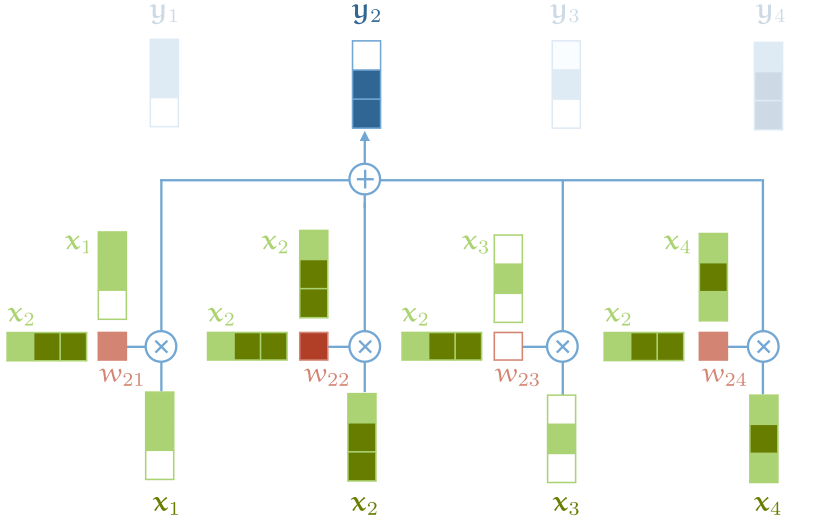

In [ ]:
# Hình ảnh trực quan về self-attention. Chú ý phần softmax của weight không được biểu diễn trong ảnh
from IPython.display import HTML, SVG
display(SVG('http://peterbloem.nl/files/transformers/self-attention.svg'))

Một số thành phần để hoàn thiện transformer sẽ được bàn đến sau, nhưng đến đây là những yếu tố cơ bản của cả quá trình. Quan trọng hơn, đây chính là cơ chế duy nhất trong toàn bộ kiến trúc giúp lan truyền (propagates) thông tin giữa các vector. Mọi cơ chế khác trong transformer được sử dụng cho mỗi vector trong input sequence mà không có tương tác giữa các vector với nhau.


## Phương thức hoạt động self-attention (why it work?)

Mặc dù đơn giản, nhưng chúng ta vẫn chưa rõ ràng tại sao self-attention lại hoạt động tốt. Hãy xem qua ví dụ về *movie recommendation* để hiểu thêm một chút.

Giả sử bạn có một cửa hàng cho thuê phim, một lượng người dùng, và bạn muốn recommend phim thú vị cho khách hàng.

Chúc ta có một cách đơn giản, bằng cách tạo ra những feature cho movie, như là về mức độ romance, có bao nhiêu thời lượng action, và sau đó tạo ra một feature cho những user: họ thích romance và action ở mức độ nào. Khi ta làm được điều này, dot product của 2 feature vector sẽ cho thấy một score về mức độ phù hợp những thuộc tính của bộ phim so với cái mà user thích.

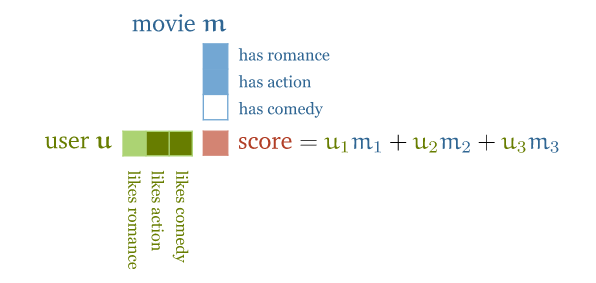

Nếu feature cho thấy dấu hiệu phù hợp giữa user và movie hay movie có romance với user thích romance hoặc movie không romance với user ghét romance - thì khi đó kết quả của dot product sẽ cho một kết quả tích cực (positive term) về feature đó. Nếu feature có dấu hiệu không phù hợp - movie romance với user ghét romance hoặc ngược lại - kết quả sẽ là tiêu cực (negative term)

Hơn nữa, độ lớn của các feature thể hiện độ ảnh hưởng/đóng góp của feature vào total score, ví dụ: một move có thể có ít romance, nhưng không gây chú ý (không đủ romance để nhận thấy), hoặc một user đơn giản là không thích romance, nhưng cũng không ghét

Hiển nhiên, việc thu thập những feature như vậy là không thực tế. Đánh dấu(annotating) một database với hàng triệu movie là vô cùng tốn kém, và đánh dấu (annotating) user với những gì họ thích và ghét là bất khả thi.

Thay vào đó, chúng ta sẽ biến các movie feature và user feature thành tham số (parameters) của model. Sau đó yêu cầu user đưa ra một vài movie mà họ thích rồi optimize user feature và movie feature để dot product của họ khớp với những thứ đã thích.

Dù vậy, chúng ta không cho model biết ngữ nghĩa của các feature, trong thực tế, hóa ra sau khi training, các feature thực sự phản ánh và biểu hiện ngữ nghĩa về nội dung phim


> 2 feature đầu tiên đã học từ 1 basic matrix factorization model. Model không có quyền truy cập vào bất kì thông tin nào về nội dung phim, thứ mà chỉ có user thích. Chú ý rằng những movie được sắp xếp từ low-brow đến high-brow theo trục tung, và từ mainstream tới quirky theo trục hoành [4]



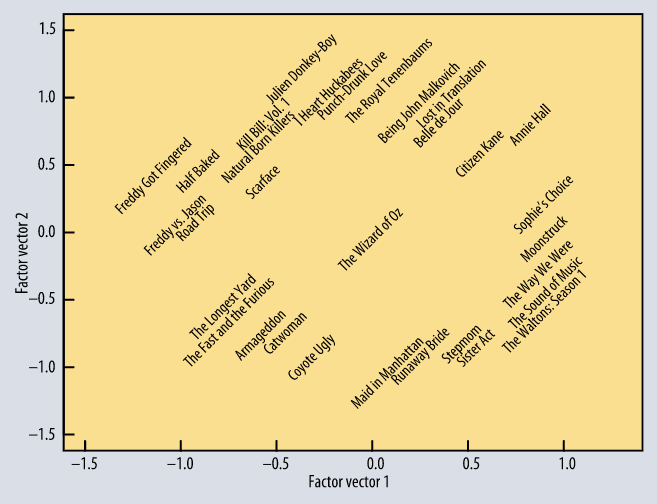

Đây là nguyên tắc cơ bản trong cách làm việc của self-attention. Giả sử ta đang làm việc với một chuỗi từ (sequence of words). Để sử dụng self-attention, đơn giản là gán cho mỗi từ một embedding vector $v_t$ (giá trị sẽ học). Còn được biết đến như là một embedding layer trong sequence modeling. Nó sẽ biến word sequence **the,cat,walks,on,the,street** thành vector sequence

\begin{align}
v_{the}, v_{cat}, v_{walks}, v_{on}, v_{the}, v_{street}
\end{align}

Nếu chúng ta đưa sequence này vào một lớp self-attention, output sẽ là một sequence vectors khác

\begin{align}
y_{the}, y_{cat}, y_{walks}, y_{on}, y_{the}, y_{street}
\end{align}

Với $y_{cat}$ là tổng weight (weighted sum) của toàn bộ embedding vector trong sequence đầu tiên, được đánh trọng số (weighted) bởi (normalized) dot-product với $v_{cat}$

Từ khi ta *học* xem giá trị $v_t$ nên trông như thế nào, mức độ "liên quan" của 2 từ đều do quá trình học quyết định. Trong đa số trường hợp, mạo từ **the** không quá liên quan đến ngữ cảnh diễn giải của các từ khác trong sequence; do đó, kết quả chúng ta nhận được thường sẽ là embedding $v_{the}$ sẽ có giá trị thấp, hoặc dot-product mang giá trị âm so với các từ khác. Mặt khác, để diễn giải ý nghĩa của từ **walks** trong sequence này, việc xác định ai đang "walking" sẽ hữu ích hơn. Điều này có thể xác định bởi 1 danh từ, vậy nên từ những danh từ như **cat** và động từ như **walks**, chúng ta có thể học embedding vector $v_{cat}$ và $v_{walks}$ một cách hiệu quả với dot-product để có giá trị cao hơn và mang dấu dương.

Đây là trực giác (intuation) cơ bản của self-attention. Dot-product thể hiện mức độ liên quan của 2 vector trong input sequence, với "độ liên quan" được định nghĩa bởi quá trình học, và các output vector sẽ được tính tổng weight thông qua toàn bộ input sequence, với các weight được quyết định bởi dot product.

Trước khi chuyển sang phần tiếp theo, ta cần lưu ý các thuộc tính sau, những thuộc tính không bình thường (unusual) trong cơ chế seq-to-seq:


*   Không (Chưa) có tham số. Những gì basic self-attention thực sự làm được quết định hoàn toàn bởi cách tạo ra input sequence. Kĩ thuật "upstream", giống như một ebedding layer, sẽ thúc đẩy self-attention bằng cách học học đại diện (learning representations) với những dot-product cụ thể (cho dù chúng ta sẽ thêm một số tham số ở sau)
*   Self-attention coi input của nó là một tập hợp (set), chứ không phải một chuỗi (sequence). Nếu ta hoán vị input sequence, thì output sequence vẫn sẽ giữ nguyên, ngoại trừ hoán vị sẵn cũng vậy (i.e: self-attention là hoán vị tương đương) *(đoạn này hơi khó hiểu)*. Chúng ta sẽ giảm thiểu điều này phần nào khi xây dựng đầy đủ transformer, nhưng self-attention bản thân nó thực sự bỏ qua bản chất tuần tự (sequential) của input.



## Pytorch: basic Self-attention

"What I cannot create, I do not understand" - Feynman.

Chúng ta sẽ xây dựng một transformers đơn giản để hiểu hơn về nó, ở đây sử dụng Pytorch

Thứ đầu tiên chúng ta cần làm là biểu diễn self-attention trong các phép nhân matrix. Cách đơn giản nhất để là điều này là sử dụng vòng lặp qua toàn bộ các vector để tính toán weight và output, tuy nhiên sẽ vô cùng chậm.

Chúng ta sẽ biểu diễn input, một chuỗi các vector $t$ có kích thước $k$ chiều (dimension) là một ma trận $X^{t*k}$. Bao gồm một minibatch $b$ chiều, sẽ cho ta một input tensor có kích thước $(b,t,k)$

Tập các raw dot-product $w_{ij}'$ tạo thành 1 matrix mà chúng ta có thể tính toán bằng cách nhân $X$ với chuyển vị của nó ($X * X^T$)

In [5]:
import torch
import torch.nn.functional as func
import numpy as np

# giả sử ta có một số tensor x với kích thước (b,t,k)

np.random.seed(0)
x_ = np.random.randint(1,10,(2,3,5))
x = torch.tensor(x_, dtype=torch.double)
print("shape: ", x.size())
x

shape:  torch.Size([2, 3, 5])


tensor([[[6., 1., 4., 4., 8.],
         [4., 6., 3., 5., 8.],
         [7., 9., 9., 2., 7.]],

        [[8., 8., 9., 2., 6.],
         [9., 5., 4., 1., 4.],
         [6., 1., 3., 4., 9.]]], dtype=torch.float64)

In [8]:
# chuyển vị ở chiều của vector
print("shape: ", x.transpose(1,2).size())
x.transpose(1,2)


shape:  torch.Size([2, 5, 3])


tensor([[[6., 4., 7.],
         [1., 6., 9.],
         [4., 3., 9.],
         [4., 5., 2.],
         [8., 8., 7.]],

        [[8., 9., 6.],
         [8., 5., 1.],
         [9., 4., 3.],
         [2., 1., 4.],
         [6., 4., 9.]]], dtype=torch.float64)

In [9]:
raw_weights = torch.bmm(x, x.transpose(1,2))
print("shape: ", raw_weights.size())
raw_weights

# - torch.bmm is a batched matrix multiplication. It 
#   applies matrix multiplication over batches of 
#   matrices.

# - torch.bmm là một phép nhân matrix theo batch.
#   nó áp dụng phép nhân matrix qua các tập các 
#   batch matrix

shape:  torch.Size([2, 3, 3])


tensor([[[133., 126., 151.],
         [126., 150., 175.],
         [151., 175., 264.]],

        [[249., 174., 145.],
         [174., 139., 111.],
         [145., 111., 143.]]], dtype=torch.float64)

Sau đó, chúng ta biến các raw weight $w_{ij}'$ thành các giá trị dương có tổng bằng 1 bằng cách áp dụng softmax theo hàng (*row-wise*):

In [10]:
weights = func.softmax(raw_weights, dim=2)
print("shape: ", weights.size())
weights

shape:  torch.Size([2, 3, 3])


tensor([[[1.5230e-08, 1.3888e-11, 1.0000e+00],
         [5.2429e-22, 1.3888e-11, 1.0000e+00],
         [8.4086e-50, 2.2274e-39, 1.0000e+00]],

        [[1.0000e+00, 2.6786e-33, 6.8136e-46],
         [1.0000e+00, 6.3051e-16, 4.3596e-28],
         [8.8080e-01, 1.5096e-15, 1.1920e-01]]], dtype=torch.float64)

Cuối cùng, để tính toán output sequence, ta nhân weight với matrix $X$ (kh: $weight * X$). Điều này dẫn đến một batch output matrix $Y$ có kích thước $(b, t, k)$ với các hàng là tổng trọng số (weighted) của các hàng $X$.

In [11]:
y = torch.bmm(weights, x)
print("shape: ", y.size())
y

shape:  torch.Size([2, 3, 5])


tensor([[[7.0000, 9.0000, 9.0000, 2.0000, 7.0000],
         [7.0000, 9.0000, 9.0000, 2.0000, 7.0000],
         [7.0000, 9.0000, 9.0000, 2.0000, 7.0000]],

        [[8.0000, 8.0000, 9.0000, 2.0000, 6.0000],
         [8.0000, 8.0000, 9.0000, 2.0000, 6.0000],
         [7.7616, 7.1656, 8.2848, 2.2384, 6.3576]]], dtype=torch.float64)

Kết luận: Tích 2 matrix và hàm softmax sẽ cho ta basic self-attention

## Additional tricks

Cơ chế self-attention thực sự được sử dụng trong các mô hình transformers hiện đại dựa vào 3 kĩ thuật sau đây.

### 1) Queries, keys và values

Mỗi input vector $x_i$ được sử dụng theo 3 cách khác nhau trong self-attention:


*   Nó so sánh với mọi vector khác để tạo ra các trọng số (weights) cho chính nó ở output $y_i$ **(query)**
*   Nó so sánh với mọi vector khác để tạo ra các trọng số (weights) cho ouput của vector thứ $j$ ($j$-th) $y_j$ **(key)**
*   Nó được sử dụng như một phần của tổng weight (weighted sum) để tính toán từng output vector khi các trọng số (weight) đã được tạo ra **(value)**



Những giá trị này gọi là query, key, value (chúng ta sẽ tìm hiểu sau). Trong basic self-attention mà ta đã biết, mỗi input vector phải đóng cả 3 vai trò trên. Ta sẽ làm bước tính đạo hàm cho mỗi vector mới dễ dàng hơn bằng cách sử dụng một phép biến đổi tuyến tính (linear transformation) cho input vector gốc (original). Nói cách khác, ta thêm vào 3 weight matrix kích thước $k * k$ là $W_q$, $W_k$, $W_v$ và tính toán linear transformation của mỗi $x_i$, cho 3 phần khác nhau của self-attention:

\begin{align}
q_i = W_q x_i \qquad k_i = W_k x_i \qquad v_i = W_v x_i
\end{align}

$$w_{ij}' = q_i^T k_j$$


$$w_{ij} = softmax(w_{ij}')$$


$$y_i = \sum_j w_{ij} v_j$$

Điều này sẽ cho lớp self-attention một vài tham số điều khiển/training được (contronllable parameters), và cho phép nó can thiệp vào các vector đang truyền vào để phù hợp với 3 vai trò của các vectors

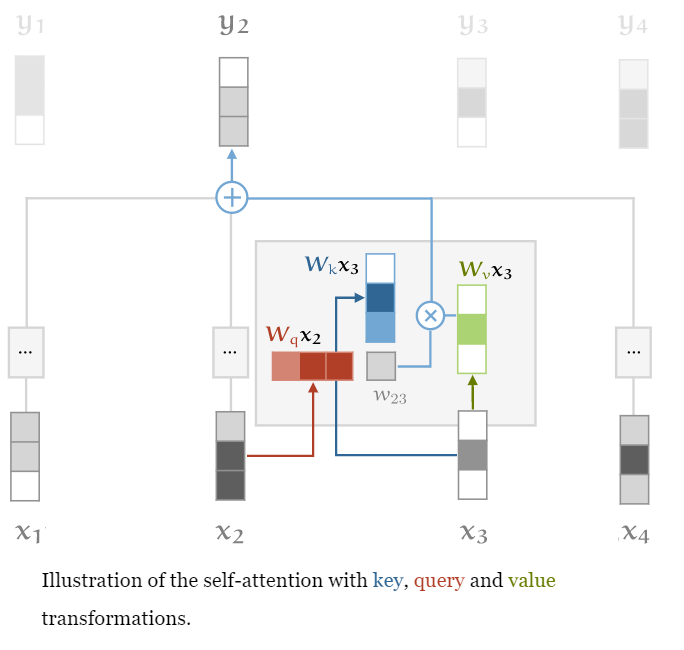

### 2) Scaling the dot product

Hàm softmax rất nhạy cảm với các giá trị input quá lớn. Nó sẽ "giết chết" (kill) đạo hàm (gradient) và làm chậm quá trình học, hoặc tệ hơn là nó sẽ dừng luôn. Vì trung bình (average) của dot product tăng dần theo embedding chiều $k$, nó giúp cho việc bùng nổ (scale) của dot product chậm lại một chút để ngăn việc input của hàm softmax trở nên quá lớn:

$$w_{ij}' = \frac{q_i^Tk_j}{\sqrt k}$$



> Tại sao là $\sqrt k$? Giả sử một vector trong $\mathbb{R}^k$ với tất cả giá trị là $c$. Độ dài Euclidean của nó là $\sqrt kc$. Do đó, ta chia cho số lượng mà sự gia tăng về chiều làm tăng độ dài trung bình vector (*Therefore, we are dividing out the amount by which the increase in dimension increases the length of the average vectors.*)



### 3) Multi-head attention

Cuối cùng, ta phải tính đến thực tế là, một từ có thể mang nghĩa khác nhau với những từ lân cận khác nhau. Giả sử ta có một ví dụ: **mary**, **gave**, **roses**, **to**, **susan**, ta thấy rằng **gave** có quan hệ khác với các phần khác nhau của câu. **mary** là người tặng (giving), **roses** là thứ được tặng, và **susan** là người nhận.

Trong cơ chế single self-attention, tất cả thông tin này được tổng chung với nhau. Nếu **susan** tặng hoa thay vì **mary**, output vector $y_{gave}$ vẫn có giá trị như cũ, cho dù nghĩa của từ đã thay đổi.

Chúng ta có thể cho self-attention một khả năng phân biệt tuyệt vời bằng cách gộp (combining) các self-attention với nhau (được đánh chỉ mục bằng $r$), với mỗi đơn vị attention sẽ có các matrix $W_q^r$, $W_k^r$, $W_v^r$. Những đơn vị này được gọi là "đầu" (attention heads)

Đối với input $x_i$, mỗi đầu attention tạo ra một output vector $y_i^r$ khác nhau. Chúng ta sẽ nối chúng lại, sau đó cho qua một hàm linear transformation để giảm chiều về $k$.

**Hiệu quả của multi-head self-attention**. Cách đơn giản nhất để hiểu multi-head self-attention là coi nó như các bản copy nhỏ của cơ chế self-attention được chạy song song, với mỗi đầu có các giá trị/thông tin key, value, và query của riêng nó. Cơ chế này hoạt động khá tốt, nhưng với $R$ head, self-attention sẽ hoạt động chậm đi $R$ lần.

Cái khó ló cái khôn, ta vẫn có thể giải quyết vấn đề này: có một cách để implement multi-head self-attention mà vẫn nhanh như gió như chạy single-head, mà vẫn đảm bảo được lợi ích của việc có nhiều matrix attention chạy song song. Để thực hiện điều này, ta chia các vector đầu vào thành nhiều phần: nếu input đầu vào có 256 chiều, và ta có 8 attention heads, ta sẽ chia nó thành 8 phần 32 chiều. Với mỗi phần, ta sẽ tạo keys, values, và queries với 32 chiều cho mỗi loại. Điều này có nghĩa là các matrix $W_q^r$, $W_k^r$, $W_v^r$ sẽ có kích thước $32 * 32$

Để hiểu đơn giản hơn, ta sẽ thử triển khai cách tốn kém đầu tiên của multi-head ngay sau đây.



## In Pytorch: complete self-attention

Giờ ta sẽ implement self-attention dựa trên những gì đã có, sau đó đóng gói lại để dùng lần sau.

In [1]:
import torch
from torch import nn
import torch.nn.functional as func

In [2]:
class SelfAttention(nn.Module):
  def __init__(self, k , heads=8):
    super().__init__()
    self.k = k
    self.heads = heads

Ta biết $h$ attention heads được chia thành 3 matrix $W_q^r$, $W_k^r$, $W_v^r$, nhưng sẽ có hiệu quả hơn cho các head khi gộp chúng vào thành 3 matrix đơn kích thước $k * hk$, từ đó, ta có thể tính toán các queries, keys, values đã nối trong 1 phép nhân duy nhất

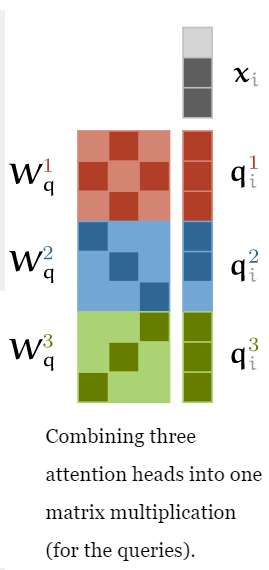

In [3]:
class SelfAttention(nn.Module):
  def __init__(self, k , heads=8):
    super().__init__()
    self.k = k
    self.heads = heads
    
    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues = nn.Linear(k, k * heads, bias=False)

    # This unifies the outputs of the different heads into 
	  # a single k-vector
    self.unifyheads = nn.Linear(heads * k, k)


Giờ chúng ta có thể implement phần tính toán của self-attention (forward). Đầu tiên, chúng ta sẽ tính toán query, key, và value:

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, k , heads=8):
    super().__init__()
    self.k = k
    self.heads = heads
    
    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues = nn.Linear(k, k * heads, bias=False)

    # This unifies the outputs of the different heads into 
	  # a single k-vector
    self.unifyheads = nn.Linear(heads * k, k)
  
  def forward(self, x):
    b, t, k = x.size()
    h = self.heads

    queries = self.toqueries(x).view(b, t, h, k)
    keys = self.tokeys(x).view(b, t, h, k)
    values = self.tovalues(x).view(b, t, h, k)

In [6]:
# example linear
b, t, k = x.size()
print(x.size())

linear_ex = nn.Linear(k, k*8, bias=False)
out_linear = linear_ex(x.float())
print(out_linear.shape)
out_linear = linear_ex(x.float()).view(b,t,8,k)
print(out_linear.shape)

torch.Size([2, 3, 5])
torch.Size([2, 3, 40])
torch.Size([2, 3, 8, 5])


Output của mỗi linear module sẽ có kích thước $(b, t, h*k)$, ta sẽ reshape lại thành $(b, t, h, k)$ để khớp với chiều của mỗi head



Tiếp theo, ta sẽ tính toán dot-product. Cơ chế này hoạt động như nhau ở mỗi head, nên chúng ta sẽ "gấp" (fold) các head vào chiều của batch (batch dimension). Điều này sẽ giúp ta có thể dùng `torch.bmm()` như trước đó, và toàn bộ key, query, value sẽ được coi như 1 batch lớn.

Vấn đề là kích thước của head và batch không khớp với nhau, nên ta cần transpose trước khi reshape. (Các bước này tốn kém nhưng không tránh được)

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, k , heads=8):
    super().__init__()
    self.k = k
    self.heads = heads
    
    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues = nn.Linear(k, k * heads, bias=False)

    # This unifies the outputs of the different heads into 
	  # a single k-vector
    self.unifyheads = nn.Linear(heads * k, k)
  
  def forward(self, x):
    b, t, k = x.size()
    h = self.heads

    # compute linear transformation
    queries = self.toqueries(x).view(b, t, h, k)
    keys = self.tokeys(x).view(b, t, h, k)
    values = self.tovalues(x).view(b, t, h, k)

    # fold heads into batch dimension
    # contiguous does nothing, it's just make sure transpose will work
    keys = keys.transpose(1,2).contiguous().view(b*h, t, k)
    queries = queries.transpose(1,2).contiguous().view(b*h, t, k)
    values = values.transpose(1,2).contiguous().view(b*h, t, k)

In [ ]:
# example
b, t, k = x.size()
h=8
print(x.size())

print("linear:.........")
linear_ex = nn.Linear(k, k*8, bias=False)
out_linear = linear_ex(x.float())
print(out_linear.shape)
out_linear = linear_ex(x.float()).view(b,t,8,k)
print(out_linear.shape)

#fold
print("fold:.......")
out_linear_ = out_linear.transpose(1,2)
print("tranpose(1,2): ", out_linear.shape)
out_linear_ = out_linear.transpose(1,2).contiguous()
print("contiguous:", out_linear_.shape)
out_linear_ = out_linear.transpose(1,2).contiguous().view(b*h, t, k)
print("view(shape):", out_linear_.shape)

torch.Size([2, 3, 5])
linear:.........
torch.Size([2, 3, 40])
torch.Size([2, 3, 8, 5])
fold:.......
tranpose(1,2):  torch.Size([2, 3, 8, 5])
contiguous: torch.Size([2, 8, 3, 5])
view(shape): torch.Size([16, 3, 5])


In [ ]:
sam = torch.tensor([[1,2,3],[4,5,6]])
sam_ = sam.transpose(0,1)
print(sam_)
sam_ = sam.transpose(0,1).contiguous()
print(sam_)

tensor([[1, 4],
        [2, 5],
        [3, 6]])
tensor([[1, 4],
        [2, 5],
        [3, 6]])


Như ta đã biết, dot product có thể được tính toán bằng 1 phép nhân matrix duy nhất, nhưng giờ là giữa query với key

Tuy nhiên, trước đó ta đã giảm sự bùng nổ giá trị (scaling) của dot product bằng cách chia cho $\sqrt k$, thay vào đó ta sẽ chia cho $\sqrt[4]{k}$ trước khi nhân chúng với nhau. Điều này sẽ tiết kiệm bộ nhớ cho ta với các sequence dài

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, k , heads=8):
    super().__init__()
    self.k = k
    self.heads = heads
    
    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues = nn.Linear(k, k * heads, bias=False)

    # This unifies the outputs of the different heads into 
	  # a single k-vector
    self.unifyheads = nn.Linear(heads * k, k)
  
  def forward(self, x):
    b, t, k = x.size()
    h = self.heads

    # compute linear transformation
    queries = self.toqueries(x).view(b, t, h, k)
    keys = self.tokeys(x).view(b, t, h, k)
    values = self.tovalues(x).view(b, t, h, k)

    # fold heads into batch dimension
    # contiguous does nothing, it's just make sure transpose will work
    keys = keys.transpose(1,2).contiguous().view(b*h, t, k)
    queries = queries.transpose(1,2).contiguous().view(b*h, t, k)
    values = values.transpose(1,2).contiguous().view(b*h, t, k)

    # stop scaling
    queries = queries / (k ** (1/4))
    keys = keys / (k ** (1/4))

    # - get dot product of queries and keys, and scale
    dot = torch.bmm(queries, keys.transpose(1,2)).cuda()
    # dot has size (b*h, t, t) containing raw weights

    # softmax
    dot = func.softmax(dot, dim=2)

Ta sử dụng self-attention với value để cho đầu ra ở mỗi attention head

In [ ]:
    # apply attention to values
    out = torch.bmm(dot, values).view(b, h, t, k)

Để tổng hợp các attention head, ta transpose một lần nữa, từ đây kích thước của head và embedding sẽ khớp với nhau, và reshape để lấy các vector đã nối của chiều $kh$. Sau đó ta sẽ đưa chúng qua lớp `unifyheads` để chiếu (project) chúng về $k$ chiều.

In [ ]:
    # swap h, t, back, unify heads
    out = out.tranpose(1,2).contiguous().view(b,t,h*k)
    return self.unifyheads(out)

Vậy là ta đã có đủ: multi-head, scaled dot-product self-attention.
Hãy tổng hợp lại code

In [ ]:
#@title Final self-attention

import torch
from torch import nn
import torch.nn.functional as func


class SelfAttention(nn.Module):
  def __init__(self, k, heads=8):
    super().__init__()
    # assign properties
    self.k = k
    self.heads = heads

    # break the embedding into 'heads' chunks 
    # and feed each other to a different attention head
    s = k // heads

    # compute linear for queries, keys, values for all heads
    self.toqueries = nn.Linear(k, k * heads, bias = False)
    self.tokeys = nn.Linear(k, k * heads, bias = False)
    self.tovalues = nn.Linear(k, k * heads, bias = False)

    # This unifies the outputs of the different heads into 
	  # a single k-vector
    self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
    b, t, k = x.size()
    # print("Attention input:", x.size())
    h = self.heads

    assert k == self.k, f'Input embedding dim ({k}) should match layer embedding dim ({self.k})'

    # compute linear transformation and reshape from (b,t,h*k) to (b,t,h,k)
    queries = self.toqueries(x).view(b,t,h,k)
    keys = self.tokeys(x).view(b,t,h,k)
    values = self.tovalues(x).view(b,t,h,k)

    # fold heads into batch dimension
    # contiguous does nothing, it's just make sure transpose will work
    queries = queries.transpose(1,2).contiguous().view(b*h, t, k)
    keys = keys.transpose(1,2).contiguous().view(b*h, t, k)
    values = values.transpose(1,2).contiguous().view(b*h, t, k)

    # dot product scalling
    queries = queries / (k ** (1/4))
    keys = keys / (k ** (1/4))

    # get dot product of query, key, scale
    dot = torch.bmm(queries, keys.transpose(1,2))
    # dot has size (b*h, t, k) containing raw weights
    
    assert dot.size() == (b*h, t, t)

    dot = func.softmax(dot, dim=2)
    # dot now contains row-wise normalized weights

    # apply self-attention to values
    out = torch.bmm(dot, values).view(b, h, t, k)
    # print("Attention out:",out.size())

    # swap h, t back, unify heads
    out = out.transpose(1,2).contiguous().view(b, t, h*k)
    return self.unifyheads(out)

In [ ]:
# example
b, t, k = x.size()
print(x.shape)

att0 = SelfAttention(k,8)
att0.forward(x.float())

torch.Size([2, 3, 5])
Attention input: torch.Size([2, 3, 5])
Attention out: torch.Size([2, 8, 3, 5])


tensor([[[ 0.0663,  0.8720, -3.5499,  1.3931, -3.9403],
         [-0.0135,  0.9120, -3.3051,  1.6167, -3.7714],
         [ 0.3884,  0.5798, -3.3901,  1.6779, -3.5419]],

        [[-0.0483,  1.0708, -3.6955,  0.7523, -3.8765],
         [-0.4026,  1.0867, -3.8381,  0.8723, -4.3180],
         [-0.1412,  0.9940, -3.7119,  1.2712, -4.6138]]],
       grad_fn=<AddBackward0>)

# Building Transformer - Người máy biến hình

Một người máy biến hình transformer thì không thể chỉ là 1 cái xe. Transformer cũng vậy, nó không chỉ là 1 lớp self-attention, nó là cả một *kiến trúc*, nhưng chúng ta sẽ sử dụng định nghĩa sau đây:


> Bất kì kiến trúc nào được thiết kế để xử lý một tập các đơn vị được kết nối (connected set of units) - ví dụ như các token trong 1 chuỗi hoặc các pixel trong 1 bức ảnh -  nơi mà tương tác duy nhất giữa các unit là thông qua self-attention

Giống như trong các kĩ thuật khác, vd như convolutions, một cách tiếp cận tiêu chuẩn hơn được sử dụng nhằm xây dựng/mở rộng lớp self-attention thành một mạng lớn hơn. Bước đầu tiên là gom self-attention lại thành 1 block để có thể tái sử dụng.


## The transformer block

Có vài biến thể cho cách xây dựng 1 khối transformer cơ bản, nhưng hầu hết trong số chúng sẽ trông như sau:

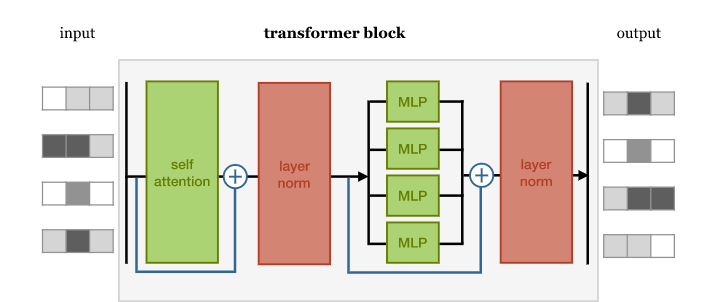

Từ hình trên, ta sẽ có cấu trúc tuần tự: <font color='green'>self-attention layer</font>, <font color='red'>normalization layer</font>, <font color='red'>feed forward layer</font> (một node MLP apply độc lập trên mỗi vector), và một <font color='red'>normalization layer</font> khác. Kết nối tắt (Residual connections) được thêm vào 2 đầu trước lớp normalization. Thứ tự của các thành phần khác nhau không quá quan trọng; điều quan trọng là phải kết hợp self-attention với feed-forward cục bộ (local feed-forward), và thêm các normalization và residual connections

> Normalization và residual connections là các trick thường dùng để giúp mạng neural train nhanh hơn và chính xác hơn. Lớp normalization chỉ được dùng trên chiều embedding ( The layer normalization is applied over the embedding dimension only.)

Phần code:

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, k, heads):
    super().__init__()

    self.attention = SelfAttention(k, heads=heads)

    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.feedforward = nn.Sequential(
        nn.Linear(k, 4*k),
        nn.ReLU(),
        nn.Linear(4*k, k)
    )

  def forward(self, x):
    attended = self.attention(x.float())
    x = self.norm1(attended + x)
    feedff = self.feedforward(x)
    return self.norm2(feedff + x)

In [ ]:
#@title example
print("self attention")
print(att0(x.float()))

print("\ntransformer:")
trans0 = TransformerBlock(x.shape[-1], 8)
trans0(x.float())

self attention
tensor([[[-1.7030, -2.9186,  3.2203, -2.4980,  6.7748],
         [ 1.5346, -0.2973, -1.5383,  0.1170,  0.3576],
         [ 0.2332,  1.9109, -2.3409,  0.3259,  0.5586]],

        [[-0.7686, -2.7475,  3.6787, -2.5732,  5.8210],
         [ 0.4782, -0.4202, -2.7884,  0.7267,  0.4449],
         [-0.3352,  1.0968, -2.0540,  1.0165,  0.8277]]],
       grad_fn=<AddBackward0>)

transformer:


tensor([[[ 0.2230, -1.0705, -0.2243, -0.7250,  1.7968],
         [-1.2187,  1.5516, -0.4740, -0.5900,  0.7311],
         [ 0.0767,  0.2879,  1.2706, -1.8075,  0.1723]],

        [[ 0.7906,  1.0380,  0.1824, -1.7935, -0.2175],
         [ 0.0686,  1.7360, -0.2147, -1.3745, -0.2154],
         [ 0.2052, -1.2474, -0.2403, -0.4816,  1.7641]]],
       grad_fn=<NativeLayerNormBackward0>)

Chúng ta đã tạo ra những lựa chọn tùy tiện trong việc tạo lớp ẩn của tầng feedforward lớn gấp 4 lần so với input và output. Các values nhỏ hơn sẽ hoạt động tốt hơn và tiết kiệm hơn, nhưng nó nên lớn hơn các lớp input/ouput.

## Classification Transformer

Mạng transformer đơn giản nhất chúng ta có thể build là một *phân lớp tuần tự (sequence classifier)*. Chúng ta sẽ thử phân loại trên dataset **AIVIVN 2019: Sentiment Analysis Challenge**: dữ liệu gồm các reviews về sản phẩm thương mại điện tử, phân loại được đánh nhãn <font color='cyan'>0 - positive</font> và <font color='orange'>1 - negative</font> (chỉ ra phản hồi tích cực hay tiêu cực về sản phẩm)

Trái tim của kiến trúc này đơn giản là một chuỗi lớn các transformer block. Tất cả những gì ta cần làm là điều chỉnh cách đưa dữ liệu của input sequence, và các chuyển đổi (transform) sang output sequence đầu cuối thành một bộ phân lớn đơn lẻ.

Data sử dụng sẵn có

## Output: producing a classification

Cách phổ biến nhất để build một bộ phân lớp tuần tự (sequence classifier) bên ngoài lớp seq-to-seq, là áp dụng pooling trung bình toàn cục (global average pooling) vào ouput sequence cuối cùng, và ánh xạ (map) kết quả qua một lớp softmax vector để nhận accuracy

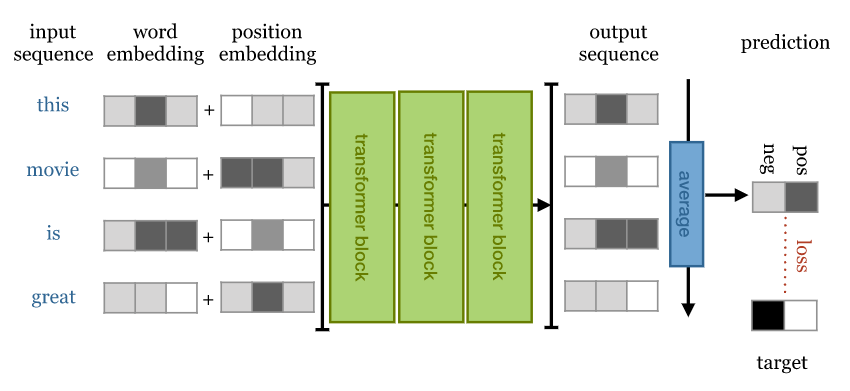

> Tổng quan một mạng transformer phân lớp đơn giản. Output sequence được tính trung bình (averaged) để tạo ra 1 vector duy nhất đại diện (represent) cho cả sequence. Vector này được chiếu xuống 1 vector mới với mỗi element là 1 class, sau đó đưa qua hàm softmax để nhận xác suất (probabilities).

## Input: using positions

Ta đã nói về nguyên tắc/chỉ tiêu của một embedding layer. Đây là những thứ chúng ta sẽ dùng để biểu diễn từ (represent the word)

Dù vậy, như đã đề cập, chúng ta đang xếp chồng (stacking) các lớp hoán vị tương đương (permutation equivariant), và average pooling cuối là hoán vị bất biến (permutation invariant), vậy nên về cơ bản toàn bộ mạng đang là hoán vị bất biến. Nói một cách đơn giản: nếu ta trộn (shuffle up) các từ trong câu lên, ta vẫn sẽ có kết quả phân lớp y hệt như cũ. Nói một cách rõ ràng hơn thì chúng ta đang muốn mô hình ngôn ngữ đỉnh-của-chóp (state-of-the-art language model) của mình tối thiểu phải có ngữ nghĩa/độ nhạy cảm (sensitive) với thứ tự của các từ (word order), vậy nên điều này cần phải được khắc phục.

Giải pháp vô cùng đơn giản: ta sẽ tạo ra một vector thứ 2 với độ dài tương đương nhằm biểu diễn thứ tự của từ trong câu hiện tại, và thêm nó vào tầng word embedding. Qua đó ta sẽ có 2 lựa chọn sau:

**position embeddings**: Chúng sẽ *nhúng* (embed) vị trí như ta đã làm với các từ. Giống như việc tạo ra embedding vector $v_{cat}$ và $v_{susan}$, ta sẽ tạo ra embedding vector $v_{12}$ và $v_{25}$. Dựa vào việc chúng ta mong muốn sequence dài bao nhiêu. Hạn chế là chúng ta sẽ phải xem trình tự của mọi độ dài trong quá trình training, nếu không thì các position embeddings liên quan sẽ không được train. Điểm cộng là nó hoạt động rất tốt và dễ triển khai.

**position encodings**: Position encoding hoạt động giống như embedding, ngoại trừ việc ta không học các position vector, ta chỉ chọn một số function f : $\mathbb{N} \to \mathbb{R}^k$ để ánh xạ position vào vector giá trị thực (real valued vector), và qua đó cho phép mạng tìm hiểu (figure) cách diễn giải những encodings này. Ưu điểm của giải pháp này là nếu ta chọn được function tốt, mạng (network) có khả năng sẽ xử lý được với những sequence dài hơn cả những cái mà nó đã được học trong quá trình training (nó không giống như việc xử lý tốt, tuy nhiên ta có thể check sau). Điểm trừ là việc lựa chọn encoding function là một siêu tham số phức tạp (complicated hyperparameter), và cách triển khai nó cũng phức tạp hơn.

Để đơn giản dễ hiểu, ta sẽ dùng position embedding

In [ ]:
#@title Complete transformer

class TransformerBlock(nn.Module):
  def __init__(self, k, heads):
    super().__init__()

    self.attention = SelfAttention(k, heads=heads)

    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.feedforward = nn.Sequential(
        nn.Linear(k, 4*k),
        nn.ReLU(),
        nn.Linear(4*k, k)
    )

  def forward(self, x):
    attended = self.attention(x.float())
    x = self.norm1(attended + x)
    feedff = self.feedforward(x)
    x = self.norm2(feedff + x)
    return x

class Transformer(nn.Module):
  def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
    super().__init__()

    # size of dictionary, get len(unique) to get this
    self.num_token = num_tokens
    self.token_emb = nn.Embedding(embedding_dim=k, num_embeddings=num_tokens)
    self.pos_emb = nn.Embedding(embedding_dim=k, num_embeddings=seq_length)
  
    # The sequence of transformer blocks that does all the 
    # heavy lifting
    transformerBlocks = []
    for i in range(depth):
      transformerBlocks.append(TransformerBlock(k=k, heads=heads))
    self.transformerBlocks = nn.Sequential(*transformerBlocks)

    # map the final output sequence to class logits
    self.toprobs = nn.Linear(k, num_classes)

  def forward(self, x):
    """
    :param x: A (b, t) tensor of integer values representing 
              words (in some predetermined vocabulary).
    :return: A (b, c) tensor of log-probabilities over the 
              classes (where c is the nr. of classes).
    """
    # generate token embedding
    # print("[DEBUG] X-input size: ", x.size())
    tokens = self.token_emb(x.long()).to(device)
    b, t, k = tokens.size()
    # print(tokens.shape)

    # generate position embedding
    positions = torch.arange(t).to(device)
    positions = self.pos_emb(positions)[None, :, :].expand(b, t, k).to(device)
    # print(positions.shape)


    x = tokens + positions
    x = self.transformerBlocks(x)
    # Average-pool over the t dimension and project to class 
    # probabilities
    x = self.toprobs(x.mean(dim=1)).to(device)
    return func.log_softmax(x, dim=1)


# embedding_size = 128
# num_heads = 8
# depth = 6
# seq_length = 512
# vocab_size = 50000
# num_classes = 2

# model = Transformer(k=embedding_size, heads=num_heads, 
#                     depth=depth, seq_length=seq_length,
#                     num_tokens=vocab_size, num_classes=num_classes)
# x = torch.rand

In [ ]:
#@title example
import numpy as np
np.random.seed(0)
x_ = np.random.randint(1,20,(4,3))
x = torch.tensor(x_, dtype=torch.double, device='cuda')
trans_ = model(x)
print(x.size())

torch.Size([4, 3])


In [ ]:
#@title example
import numpy as np

device = torch.device('cuda')

np.random.seed(0)
x_ = np.random.randint(1,20,(21,64))
x = torch.tensor(x_, dtype=torch.double).to(device='cuda')
# print(x)
# print(x.shape)
# embedding = nn.Embedding(50000, 128)
# tok = embedding(x.long())
# print(tok.shape)

# embedding = nn.Embedding(512, 128)
# pos = embedding(x.long())
# print(pos.shape)

# print(pos[None, :,:].shape)
# print(tok[None, :,:].shape)

embedding_size = 128
num_heads = 8
depth = 6
seq_length = 512
vocab_size = 50000
num_classes = 2

# sume = tok+pos
# print("sume:",sume.size())

# transb = TransformerBlock(128, 8)
# tro = transb(sume)
# print("tro:",tro.size())

transM = Transformer(128, 8, 6, 512, 50000, 2).to(device)
tro2 = transM(x.to(device='cuda'))
print("tro2:", tro2.size())


[DEBUG] X-input size:  torch.Size([21, 64])
torch.Size([21, 64, 128])
torch.Size([21, 64, 128])
Attention input: torch.Size([21, 64, 128])
Attention out: torch.Size([21, 8, 64, 128])
Attention input: torch.Size([21, 64, 128])
Attention out: torch.Size([21, 8, 64, 128])
Attention input: torch.Size([21, 64, 128])
Attention out: torch.Size([21, 8, 64, 128])
Attention input: torch.Size([21, 64, 128])
Attention out: torch.Size([21, 8, 64, 128])
Attention input: torch.Size([21, 64, 128])
Attention out: torch.Size([21, 8, 64, 128])
Attention input: torch.Size([21, 64, 128])
Attention out: torch.Size([21, 8, 64, 128])
tro2: torch.Size([21, 2])


In [ ]:
a = torch.rand(size=(1,13, 2), dtype=torch.float32)
b = torch.rand(size=(1, 1, 1), dtype=torch.float32)
loss = func.nll_loss(a, b).to(device)

RuntimeError: ignored

Với depth=6, maximum chiều dài sequence là 512, mạng transformer này đạt 85%, so sánh với RNN truyền thống thì nó train nhanh hơn. Tuy nhiên để đạt khả năng gần với con người, ta cần một mô hình sâu hơn với nhiều data hơn.

### **Excercise**: Sử dụng các phần trên cho bộ dataset AIVN

#### Download data

In [ ]:
!wget https://raw.githubusercontent.com/petrpan26/Aivivn_1/master/data/train.crash
!wget https://raw.githubusercontent.com/petrpan26/Aivivn_1/master/data/test.crash

--2022-04-02 04:09:11--  https://raw.githubusercontent.com/petrpan26/Aivivn_1/master/data/train.crash
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2258301 (2.2M) [text/plain]
Saving to: ‘train.crash’

train.crash         100%[===================>]   2.15M  --.-KB/s    in 0.06s   

2022-04-02 04:09:11 (35.5 MB/s) - ‘train.crash’ saved [2258301/2258301]

--2022-04-02 04:09:11--  https://raw.githubusercontent.com/petrpan26/Aivivn_1/master/data/test.crash
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1504165 (1.4M) [text/plain]
S

### Import lib

In [ ]:
import pandas as pd
import torch
import os
from torch import nn
import numpy as np
import re

#### Explore data

In [ ]:
!head -n20 train.crash

train_000000
"Dung dc sp tot cam on 
shop Đóng gói sản phẩm rất đẹp và chắc chắn Chất lượng sản phẩm tuyệt vời"
0

train_000001
" Chất lượng sản phẩm tuyệt vời . Son mịn nhưng khi đánh lên không như màu trên ảnh"
0

train_000002
" Chất lượng sản phẩm tuyệt vời nhưng k có hộp k có dây giày đen k có tất"
0

train_000003
":(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọng cuốn sách khá nhiều hi vọng nó sẽ nói về việc học tập của cách sinh viên trường Harvard ra sao những nỗ lực của họ như thế nào 4h sáng? tại sao họ lại phải thức dậy vào thời khắc đấy? sau đó là cả một câu chuyện ra sao. Cái mình thực sự cần ở đây là câu chuyện ẩn dấu trong đó để tự bản thân mỗi người cảm nhận và đi sâu vào lòng người hơn. Còn cuốn sách này chỉ đơn thuần là cuốn sách dạy kĩ năng mà hầu như sách nào cũng đã có. BUồn..."
1

train_000004
"Lần trước mình mua áo gió màu hồng rất ok mà đợt này lại giao 2 cái áo gió chất khác như vải mưa ý :(("
1


In [ ]:
def get_series(id, content, label):
    series_line = pd.Series({'id':id, 'content':content.strip(), 'label':label}, index=['id', 'content', 'label'])
    return series_line

def read_file(file_path, is_train=True):
  df = pd.DataFrame(columns=['id', 'content', 'label'])

  id_pattern = r"^train_\d{6}?"
  id_match = re.compile(id_pattern, re.ASCII)


  f = open(file_path)
  lines = f.readlines()
  check_multi = False
        
  temp_line = ''
  id_line = ''
  for i in range(len(lines)):
      id_line = id_match.search(lines[i])
      # print(id_line)
      # print(temp_line)
      if id_line:
          if check_multi and id_line:
              # print(id_line.group())
              temp_series = get_series(temp_line.strip().split('\n')[0], ' '.join(x for x in temp_line.strip().split('\n')[1:-1]), temp_line.strip().split('\n')[-1])
              df = df.append(temp_series, ignore_index=True)
              # print(temp_series)
              check_multi = False
          temp_line = lines[i]
      else:
          temp_line += lines[i]
          check_multi = True
      try:
          if (not check_multi) and id_match.search(lines[i+1]):
              temp_series = get_series(temp_line.strip().split('\n')[0], ' '.join(x for x in temp_line.strip().split('\n')[1:-1]), temp_line.strip().split('\n')[-1])
              df = df.append(temp_series, ignore_index=True)
              # print(temp_line)
      except:
          temp_series = get_series(temp_line.strip().split('\n')[0], ' '.join(x for x in temp_line.strip().split('\n')[1:-1]), temp_line.strip().split('\n')[-1])
          df = df.append(temp_series, ignore_index=True)
          # print(temp_line)
#         print(id_line)
  if check_multi:
      id_line = id_match.search(temp_line)
      temp_series = get_series(temp_line.strip().split('\n')[0], ' '.join(x for x in temp_line.strip().split('\n')[1:-1]), temp_line.strip().split('\n')[-1])
      df = df.append(temp_series, ignore_index=True)
      # print(temp_line)
  f.close()

  return df

train_df = read_file('train.crash')

In [ ]:
def strip_con(text):
  text.strip('"')
  return text.strip(' ')

train_df['content'] = train_df['content'].apply(strip_con)
train_df = train_df.dropna(how='any')
train_df

,id,content,label
0,train_000000,"""Dung dc sp tot cam on shop Đóng gói sản phẩm...",0
1,train_000001,""" Chất lượng sản phẩm tuyệt vời . Son mịn nhưn...",0
2,train_000002,""" Chất lượng sản phẩm tuyệt vời nhưng k có hộp...",0
3,train_000003,""":(( Mình hơi thất vọng 1 chút vì mình đã kỳ v...",1
4,train_000004,"""Lần trước mình mua áo gió màu hồng rất ok mà ...",1
...,...,...,...
16082,train_016082,"""Chẳng biết là Shop có biết đọc hay không mua ...",1
16083,train_016083,"""Cuốn này mỏng. Đọc một buổi sáng là hết. Thú ...",1
16084,train_016084,"""Mang êm chân. Đẹp """,0
16085,train_016085,"""Tôi đã nhận đc hàng.Sau đây là vài lời muốn n...",1


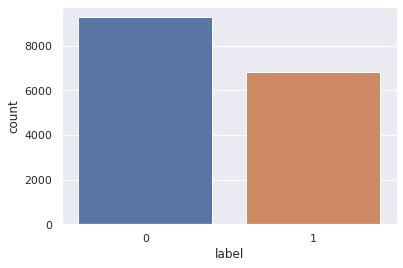

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train_df)

In [ ]:
train_df.to_csv('train.tsv', index=False, sep='\t')
train_df[:16000].to_csv('train.tsv', index=False, sep='\t')
train_df[16000:].to_csv('test.tsv', index=False, sep='\t')
train_df.to_json('train.json', orient='records', lines=True)

In [ ]:
!head -n20 train.csv

id,content,label
train_000000,"""Dung dc sp tot cam on  shop Đóng gói sản phẩm rất đẹp và chắc chắn Chất lượng sản phẩm tuyệt vời""",0
train_000001,""" Chất lượng sản phẩm tuyệt vời . Son mịn nhưng khi đánh lên không như màu trên ảnh""",0
train_000002,""" Chất lượng sản phẩm tuyệt vời nhưng k có hộp k có dây giày đen k có tất""",0
train_000003,""":(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọng cuốn sách khá nhiều hi vọng nó sẽ nói về việc học tập của cách sinh viên trường Harvard ra sao những nỗ lực của họ như thế nào 4h sáng? tại sao họ lại phải thức dậy vào thời khắc đấy? sau đó là cả một câu chuyện ra sao. Cái mình thực sự cần ở đây là câu chuyện ẩn dấu trong đó để tự bản thân mỗi người cảm nhận và đi sâu vào lòng người hơn. Còn cuốn sách này chỉ đơn thuần là cuốn sách dạy kĩ năng mà hầu như sách nào cũng đã có. BUồn...""",1
train_000004,"""Lần trước mình mua áo gió màu hồng rất ok mà đợt này lại giao 2 cái áo gió chất khác như vải mưa ý :((""",1
train_000005,""" Chất lượng sản phẩ

#### Build TorchText dataset

Ta cần build vocab/dictionary và 1 tokenize trước, ở đây có thể dùng pyvi/underthesea/..., về cách sử dụng torchtext, tham khảo bài hướng dẫn của anh Khánh: https://phamdinhkhanh.github.io/2019/08/25/PyTorch_Torchtext_Tutorial.html

In [ ]:
# !wget https://raw.githubusercontent.com/keitakurita/practical-torchtext/master/data/train.csv -O train_1.csv
# !wget https://raw.githubusercontent.com/keitakurita/practical-torchtext/master/data/test.csv -O test_1.csv

In [ ]:
#@title Assign Field
from torchtext.legacy import data, datasets, vocab
from torchtext.legacy.data import Field

tokenize = lambda x: x.split(' ')
# ID = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False, use_vocab=False)

In [ ]:
import torchtext
torchtext.__version__

'0.11.0'

In [ ]:
#@title Load data

fields = [(None, None), ("content", TEXT), ("label", LABEL)]

train_data, val_data = data.TabularDataset.splits(
                            path = '/content/',
                            train = 'train.tsv',
                            validation = 'test.tsv',
                            format = 'tsv',
                            skip_header = True,
                            fields = fields
)

In [ ]:
print('train[0]: ', train_data[0])
print('train[0].__dict__.keys(): ', train_data[0].__dict__.keys())
print('train[0].__dict__: ', train_data[0].__dict__)

train[0]:  <torchtext.legacy.data.example.Example object at 0x7f6dc0528c10>
train[0].__dict__.keys():  dict_keys(['content', 'label'])
train[0].__dict__:  {'content': ['"dung', 'dc', 'sp', 'tot', 'cam', 'on', '', 'shop', 'đóng', 'gói', 'sản', 'phẩm', 'rất', 'đẹp', 'và', 'chắc', 'chắn', 'chất', 'lượng', 'sản', 'phẩm', 'tuyệt', 'vời"'], 'label': '0'}


In [ ]:
#@title Build vocab
# ID.build_vocab(train_data)

vocab_size = 50000

TEXT.build_vocab(train_data, max_size=vocab_size-2) # -2 to make space for <unk> and <pad>
TEXT.build_vocab(val, max_size=vocab_size-2) # -2 to make space for <unk> and <pad>
LABEL.build_vocab(train_data)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
#@title Build bucketiter
from torchtext.legacy.data import Iterator, BucketIterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda')

batch_size = (32,32)

train_iter, val_iter = BucketIterator.splits(
    datasets = (train_data, val_data),
    sort = False,
    batch_sizes = batch_size,
    device = device
)

In [ ]:
## IMDB dataset
# TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
# LABEL = data.Field(sequential=False)
# train, test = datasets.IMDB.splits(TEXT, LABEL)

# TEXT.build_vocab(train, max_size=vocab_size - 2)
# LABEL.build_vocab(train)

# train_iter, test_iter = BucketIterator.splits((train, test), batch_size=batch_size, device='cuda')

In [ ]:
print('Train:')
for batch in train_iter:
    print(batch)
    
print('Val:')
for batch in val_iter:
    print(batch)

Train:

[torchtext.legacy.data.batch.Batch of size 16]
	[.content]:('[torch.cuda.LongTensor of size 16x58 (GPU 0)]', '[torch.cuda.LongTensor of size 16 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 16 (GPU 0)]

[torchtext.legacy.data.batch.Batch of size 16]
	[.content]:('[torch.cuda.LongTensor of size 16x24 (GPU 0)]', '[torch.cuda.LongTensor of size 16 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 16 (GPU 0)]

[torchtext.legacy.data.batch.Batch of size 16]
	[.content]:('[torch.cuda.LongTensor of size 16x55 (GPU 0)]', '[torch.cuda.LongTensor of size 16 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 16 (GPU 0)]

[torchtext.legacy.data.batch.Batch of size 16]
	[.content]:('[torch.cuda.LongTensor of size 16x55 (GPU 0)]', '[torch.cuda.LongTensor of size 16 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 16 (GPU 0)]

[torchtext.legacy.data.batch.Batch of size 16]
	[.content]:('[torch.cuda.LongTensor of size 16x51 (GPU 0)]', '[torch.cuda.LongTensor of size 16 (GPU 0)]')
	

In [ ]:
print('Created `train_iter` with %d batches!'%len(train_iter))
print('Created `test_iter` with %d batches!'%len(val_iter))


Created `train_iter` with 1000 batches!
Created `test_iter` with 6 batches!


In [ ]:
class BatchWrapper:
  def __init__(self, dataloader, x_var, y_var):
    # pass list of attributes for x
    self.dataloader = dataloader
    self.x_var = x_var
    self.y_var = y_var
  
  def __iter__(self):
    for batch in self.dataloader:
      # print('x_var: ', self.x_var)
      # print('y_var: ', self.y_var)

      # we assume only one input in this wrapper
      x = getattr(batch, self.x_var)
      x = x[0]
      # print(x)
      # print('x size: ', x.size())
      # we will concat y into a single vector
      if self.y_var is not None:
        y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_var], dim=1).float()
        y = y.reshape(y.size()[0])
        # print('y size: ', y.size())
      else:
        y = torch.zeros((1))
        # print('y size when y_var None:', y.size())

      yield (x,y)
  
  def __len__(self):
      return len(self.dl)


train_loader = BatchWrapper(train_iter, "content", ["label"])
val_loader = BatchWrapper(val_iter, "content", ["label"])

In [ ]:
next(train_loader.__iter__())

(tensor([[   6,    9,    8,  ...,    1,    1,    1],
         [  97,    8,    4,  ...,    1,    1,    1],
         [   6,    9,    8,  ...,    1,    1,    1],
         ...,
         [   6,    7,   35,  ...,    1,    1,    1],
         [   6,   19,   33,  ...,    1,    1,    1],
         [3988,  244,  188,  ...,    1,    1,    1]], device='cuda:0'),
 tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
         0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 1., 1., 1., 0., 1., 0., 0., 0., 1.], device='cuda:0'))

Có vẻ là khá đủ rồi, giờ ta sẽ build train pipeline

#### Train pipeline

In [ ]:
# Create model
embedding_size = 128
num_heads = 8
depth = 6
seq_length = 512
vocab_size = 50000
num_classes = 2

model = Transformer(k=embedding_size, heads=num_heads, 
                    depth=depth, seq_length=seq_length,
                    num_tokens=vocab_size, num_classes=num_classes)
model = model.to(device)
print(model)

Transformer(
  (token_emb): Embedding(50000, 128)
  (pos_emb): Embedding(512, 128)
  (transformerBlocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (toqueries): Linear(in_features=128, out_features=1024, bias=False)
        (tokeys): Linear(in_features=128, out_features=1024, bias=False)
        (tovalues): Linear(in_features=128, out_features=1024, bias=False)
        (unifyheads): Linear(in_features=1024, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
    (1): TransformerBlock(
      (attention): SelfAttention(
        (toqueries): Linear(in_features=128, out_features=1024, bias=False)
        (tokeys): Linear(in_features=12

In [ ]:
# Check cuda
if torch.cuda.is_available():
  model.cuda()
else:
  print("Running with CPU!")

In [ ]:
lr = 0.00001
lr_warmup = 10.0

optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
schedule = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / (lr_warmup / batch_size[0]), 1.0))

print(optimizer)
print(schedule)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 1e-05
    lr: 0.0
    weight_decay: 0
)


In [ ]:
!nvidia-smi

Sat Apr  2 06:24:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    60W / 149W |   4587MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##### Training loop

In [ ]:
import tqdm
from torch.utils.tensorboard import SummaryWriter

gradient_clipping = 1.0

num_epochs = 100
log_path = '/content/log'

tbw = SummaryWriter(log_dir=log_path) # Tensorboard logging

seen = 0
for epoch in range(num_epochs):
  print(f'\n Epoch {epoch}')
  
  model.train(True)
  
  # training part
  print(schedule.get_last_lr())
  for x, y in tqdm.tqdm(train_loader):
    # update all gradient param to 0
    optimizer.zero_grad()

    input = x.to(device)
    label = y.long().to(device)
    # print("\nprint input 0: ", input.size())

    # cut input to seq_length
    if input.size(1) > seq_length:
      input = input[:, :seq_length]
    output = model(input.to(device=device))
    # print("\nprint output: ", output.size())
    # print("\nprint input: ", input.size())
    # print("\nprint label: ", label.size())
    loss = func.nll_loss(output, label).to(device)

    loss.backward()

    # clip gradient
    # if the total gradient vector has a length > 1, we clip it back down to 1
    if gradient_clipping > 0:
      nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

    optimizer.step()
    schedule.step()
    

    seen += input.size(0)
    tbw.add_scalar('classification/train-loss', float(loss.item()), seen)

  # inference part
  with torch.no_grad():
    model.train(False)
    total, correct = 0.0, 0.0

    for x, y in tqdm.tqdm(val_loader):
      input = x.to(device)
      label = y.long().to(device)
      
      if input.size(1) > seq_length:
        input = input[:, :seq_length]

      output = model(input).argmax(dim=1)

      total += float(input.size(0))
      correct += float((label == output).sum().item())

    accuracy = correct/total
    print(f'-- {"test"} accuracy {accuracy:.3}')
    tbw.add_scalar('classification/train-loss', float(loss.item()), seen)




 Epoch 0
[1e-05]


500it [01:08,  7.31it/s]
3it [00:00, 10.93it/s]


-- test accuracy 0.931

 Epoch 1
[1e-05]


500it [01:08,  7.34it/s]
3it [00:00, 10.83it/s]


-- test accuracy 0.943

 Epoch 2
[1e-05]


500it [01:07,  7.41it/s]
3it [00:00, 11.03it/s]


-- test accuracy 0.92

 Epoch 3
[1e-05]


500it [01:08,  7.35it/s]
3it [00:00, 11.06it/s]


-- test accuracy 0.908

 Epoch 4
[1e-05]


500it [01:08,  7.32it/s]
3it [00:00, 10.71it/s]


-- test accuracy 0.943

 Epoch 5
[1e-05]


500it [01:08,  7.30it/s]
3it [00:00, 11.19it/s]


-- test accuracy 0.92

 Epoch 6
[1e-05]


500it [01:07,  7.37it/s]
3it [00:00, 11.02it/s]


-- test accuracy 0.908

 Epoch 7
[1e-05]


500it [01:07,  7.39it/s]
3it [00:00, 11.06it/s]


-- test accuracy 0.897

 Epoch 8
[1e-05]


500it [01:08,  7.32it/s]
3it [00:00, 11.01it/s]


-- test accuracy 0.908

 Epoch 9
[1e-05]


500it [01:08,  7.26it/s]
3it [00:00, 10.58it/s]


-- test accuracy 0.908

 Epoch 10
[1e-05]


500it [01:08,  7.32it/s]
3it [00:00, 11.02it/s]


-- test accuracy 0.885

 Epoch 11
[1e-05]


500it [01:08,  7.28it/s]
3it [00:00, 10.79it/s]


-- test accuracy 0.92

 Epoch 12
[1e-05]


500it [01:08,  7.33it/s]
3it [00:00, 11.08it/s]


-- test accuracy 0.92

 Epoch 13
[1e-05]


500it [01:08,  7.35it/s]
3it [00:00, 11.04it/s]


-- test accuracy 0.92

 Epoch 14
[1e-05]


500it [01:07,  7.37it/s]
3it [00:00, 10.74it/s]


-- test accuracy 0.92

 Epoch 15
[1e-05]


500it [01:08,  7.27it/s]
3it [00:00, 10.79it/s]


-- test accuracy 0.92

 Epoch 16
[1e-05]


500it [01:07,  7.41it/s]
3it [00:00, 11.09it/s]


-- test accuracy 0.908

 Epoch 17
[1e-05]


500it [01:07,  7.40it/s]
3it [00:00, 10.92it/s]


-- test accuracy 0.908

 Epoch 18
[1e-05]


500it [01:08,  7.32it/s]
3it [00:00, 11.04it/s]


-- test accuracy 0.908

 Epoch 19
[1e-05]


500it [01:08,  7.30it/s]
3it [00:00, 11.05it/s]


-- test accuracy 0.92

 Epoch 20
[1e-05]


500it [01:08,  7.30it/s]
3it [00:00, 10.91it/s]


-- test accuracy 0.92

 Epoch 21
[1e-05]


500it [01:08,  7.35it/s]
3it [00:00, 10.88it/s]


-- test accuracy 0.92

 Epoch 22
[1e-05]


500it [01:08,  7.26it/s]
3it [00:00, 11.09it/s]


-- test accuracy 0.931

 Epoch 23
[1e-05]


500it [01:08,  7.32it/s]
3it [00:00, 10.81it/s]


-- test accuracy 0.92

 Epoch 24
[1e-05]


500it [01:08,  7.27it/s]
3it [00:00, 11.16it/s]


-- test accuracy 0.931

 Epoch 25
[1e-05]


500it [01:08,  7.33it/s]
3it [00:00, 10.99it/s]


-- test accuracy 0.92

 Epoch 26
[1e-05]


500it [01:08,  7.31it/s]
3it [00:00, 11.11it/s]


-- test accuracy 0.931

 Epoch 27
[1e-05]


500it [01:08,  7.29it/s]
3it [00:00, 11.05it/s]


-- test accuracy 0.931

 Epoch 28
[1e-05]


500it [01:08,  7.27it/s]
3it [00:00, 11.13it/s]


-- test accuracy 0.92

 Epoch 29
[1e-05]


500it [01:08,  7.26it/s]
3it [00:00, 11.09it/s]


-- test accuracy 0.908

 Epoch 30
[1e-05]


500it [01:08,  7.34it/s]
3it [00:00, 11.06it/s]


-- test accuracy 0.908

 Epoch 31
[1e-05]


500it [01:08,  7.35it/s]
3it [00:00, 10.90it/s]


-- test accuracy 0.92

 Epoch 32
[1e-05]


500it [01:07,  7.43it/s]
3it [00:00, 10.97it/s]


-- test accuracy 0.908

 Epoch 33
[1e-05]


500it [01:07,  7.40it/s]
3it [00:00, 11.03it/s]


-- test accuracy 0.92

 Epoch 34
[1e-05]


500it [01:08,  7.32it/s]
3it [00:00, 10.92it/s]


-- test accuracy 0.92

 Epoch 35
[1e-05]


500it [01:07,  7.35it/s]
3it [00:00, 11.08it/s]


-- test accuracy 0.92

 Epoch 36
[1e-05]


500it [01:08,  7.33it/s]
3it [00:00, 11.11it/s]


-- test accuracy 0.931

 Epoch 37
[1e-05]


500it [01:08,  7.33it/s]
3it [00:00, 11.04it/s]


-- test accuracy 0.931

 Epoch 38
[1e-05]


500it [01:08,  7.28it/s]
3it [00:00, 10.85it/s]


-- test accuracy 0.931

 Epoch 39
[1e-05]


500it [01:08,  7.32it/s]
3it [00:00, 10.86it/s]


-- test accuracy 0.92

 Epoch 40
[1e-05]


249it [00:32,  7.33it/s]

**RESULT: 92% cho 800 sample, với lượng sample nhỏ và accuracy như vậy thì chưa thể đánh giá được gì, tuy nhiên nó đã chạy cho là vui rồi**

In [ ]:

# a = torch.rand(size=(1,13, 2), dtype=torch.float32)
# b = torch.rand(size=(1, 1, 1), dtype=torch.float32)
loss = func.nll_loss(output, label).to(device)

ValueError: ignored

##### HOT FIX: unmatch batch_size by [vietsivo](https://www.facebook.com/viet.vo.9212)

In [ ]:
import tqdm
from torch.utils.tensorboard import SummaryWriter
 
gradient_clipping = 1.0
 
num_epochs = 100
log_path = '/content/log'
 
# tbw = SummaryWriter(log_dir=log_path) # Tensorboard logging
 
seen = 0
for epoch in range(num_epochs):
  print(f'\n Epoch {epoch}')
 
  model.train(True)
 
  # training part
  for x, y in tqdm.tqdm(train_loader):
    # update all gradient param to 0
    optimizer.zero_grad()
 
    input = x.to(device)
    label = y.to(device)
    print("\nprint input 0: ", input.size())
 
    # cut input to seq_length
    if input.size(1) > seq_length:
      input = input[:, :seq_length]
    output = model(input.to(device=device))
    print("\nprint output: ", output.size())
    # print("\nprint input: ", input.size())
    print("\nprint label: ", label.size())
 
 
    output1 = torch.tensor(output, requires_grad=True)
    output1 = torch.reshape(output, (output1.size()[1], output1.size()[0])).to(device)
    if torch.squeeze(label) == 0:
      label_1 = torch.tensor([1, 0]).to(device)
    else:
      label_1 = torch.tensor([0, 1]).to(device)
 
    print(output1.size(), label_1.size())
    loss = func.nll_loss(output1, label_1).to(device)
 
    loss.backward()
 
    # clip gradient
    # if the total gradient vector has a length > 1, we clip it back down to 1
    if gradient_clipping > 0:
      nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
 
    optimizer.step()
    schedule.step()
 
    seen += input.size(0)
    # tbw.add_scalar('classification/train-loss', float(loss.item()), seen)
 
  # inference part
  with torch.no_grad():
    model.train(False)
    total, correct = 0.0, 0.0
 
    for x, y in val_iter:
      input = x.to(device)
      label = y.to(device)
 
      if input.size(1) > seq_length:
        input = input[:, seq_length]
 
      output = model(input).argmax(dim=1)
 
      total += float(input.size(0))
      correct += float((label == output).sum().item())
 
    accuracy = correct/total
    print(f'-- {"test"} accuracy {accuracy:.3}')
    # tbw.add_scalar('classification/train-loss', float(loss.item()), seen)

#### Load IMDB để check cấu trúc mẫu dữ liệu

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

# from torchtext import data, datasets, vocab
from torchtext.legacy import data, datasets, vocab

import numpy as np

from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter

import random, tqdm, sys, math, gzip

In [ ]:
LOG2E = math.log2(math.e)
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)
NUM_CLS = 2


In [ ]:
device = torch.device('cuda')

In [ ]:
train, test = datasets.IMDB.splits(TEXT, LABEL)

TEXT.build_vocab(train, max_size=50000 - 2)
LABEL.build_vocab(train)

train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=1, device=device)

NameError: ignored

In [ ]:
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=1, device=device)

In [ ]:
print('train[0]: ', train[0])
print('train[0].__dict__.keys(): ', train[0].__dict__.keys())
print('train[0].__dict__: ', train[0].__dict__)

train[0]:  <torchtext.legacy.data.example.Example object at 0x7fdceb66ffd0>
train[0].__dict__.keys():  dict_keys(['text', 'label'])
train[0].__dict__:  {'text': ['"roman', 'troy', 'moronie"', 'is', 'my', 'comment', 'on', 'the', 'movie.', 'what', 'else', 'is', 'there', 'to', 'say?<br', '/><br', '/>this', 'character', 'really', 'brings', 'out', 'the', 'moron', 'in', 'moronie.', 'a', 'tough', 'gangster', 'with', 'an', 'inability', 'to', 'pronounce', 'profane', 'words,', 'well,', 'it', 'seems', 'that', 'it', 'would', 'have', 'been', 'frustrating', 'to', 'be', 'tough', 'and', 'yet', 'not', 'be', 'able', 'to', 'express', 'oneself', 'intelligently.', '<br', '/><br', '/>roman', 'moronie', 'will', 'go', 'down', 'in', 'the', 'annals', 'of', 'movie', 'history', 'as', 'one', 'of', 'the', 'greatest', 'of', 'all', 'morons.<br', '/><br', '/>there', 'is', 'of', 'course', 'great', 'comedy', 'among', 'the', 'other', 'characters.', 'michael', 'keaton', 'is', 'f.a.h.', 'and', 'so', 'is', 'joe', 'piscipo.<

In [ ]:
print('Train:')
for batch in train_iter:
    print(batch)
    
print('Val:')
for batch in test_iter:
    print(batch)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.

[torchtext.legacy.data.batch.Batch of size 1 from IMDB]
	[.text]:('[torch.cuda.LongTensor of size 1x189 (GPU 0)]', '[torch.cuda.LongTensor of size 1 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 1 (GPU 0)]

[torchtext.legacy.data.batch.Batch of size 1 from IMDB]
	[.text]:('[torch.cuda.LongTensor of size 1x658 (GPU 0)]', '[torch.cuda.LongTensor of size 1 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 1 (GPU 0)]

[torchtext.legacy.data.batch.Batch of size 1 from IMDB]
	[.text]:('[torch.cuda.LongTensor of size 1x148 (GPU 0)]', '[torch.cuda.LongTensor of size 1 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 1 (GPU 0)]

[torchtext.legacy.data.batch.Batch of size 1 from IMDB]
	[.text]:('[torch.cuda.LongTensor of size 1x75 (GPU 0)]', '[torch.cuda.LongTensor of size 1 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 1 (GPU 0)]

[torchtext.legacy.data.batch.Batch of size 1 from IMDB]
	[.text]:('[torch.cuda.LongTensor o

KeyboardInterrupt: ignored

#### NOTE**

Có thể thấy trên đây là một mớ hỗn độn rất nhiều thứ, tuy nhiên tôi sẽ gộp thành vài ý chính như sau:


1.   Lỗi `Expected input batch_size (13) to match target batch_size (1).` xảy ra do output shape và label shape không khớp nhau, ở trình độ script kiddie như tôi thì việc can thiệp vào phần cuối để sửa output_shape là hơi vô lí về logic, nên sau khi xem xét lại mẫu data gốc của IMDB và cách load của họ, tôi nhận ra là đã thiếu tham số trong việc load data 
2.   Dựa trên bài viết gốc, việc load dataset sẽ có dạng `batch_size*seq_length`, tuy nhiên do tôi thiếu tham số `batch_first=True` khi build vocab, nên input size sẽ là `seq_length*batch_size`, và việc chúng ta build mô hình cho output là 2 chiều sẽ dẫn đến output là `seq_length*2`, ở đây label có chiều `nums_sample*1`, nên việc khớp data vào hàm loss `nll_loss` xảy ra lỗi, cách khắc phục tạm thời là chúng ta sẽ can thiệp bước cuối sau khi nhả output để điều chỉnh về cho khớp size như cách làm của anh vietsivo ở trên



## Text generation transformer

Tiếp theo ta sẽ thử một mô hình hồi quy tự động (autoregressive). Ta sẽ train một mô hình transformer ở cấp độ *kí tự* (*character* level) để dự đoán kí tự tiếp theo trong chuỗi. Cách thức training khá đơn giản (và đã tồn tại từ lâu ở các mô hình RNN đời trước). Ta sẽ đưa vào mô hình seq-to-seq một sequence, và yêu cầu mô hình dự đoán kí tự tiếp theo ở mọi điểm trong sequence. Nói cách khác, mục tiêu output là một sequence tương đương (same sequence) được dịch trái 1 kí tự:

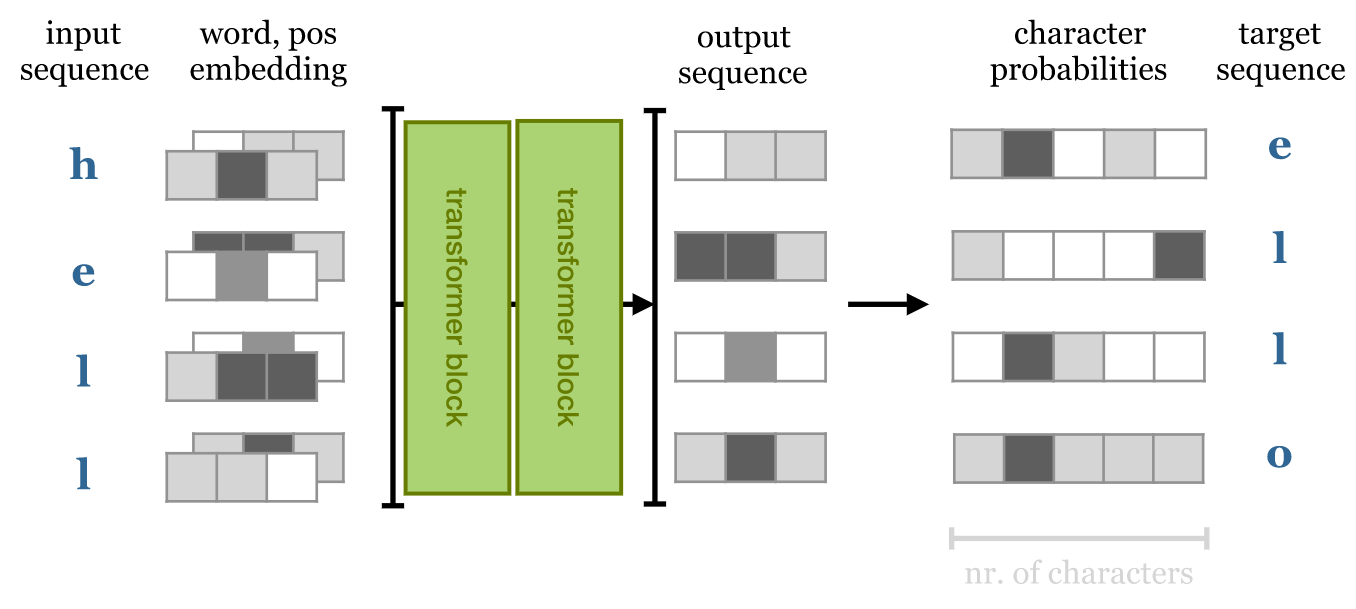

Với RNNs thì đây là tất cả những gì ta cần, vì nó không thể nhìn vào chuỗi đầu vào (cannot look forward into the input sequence): output $i$ chỉ phụ thuộc vào input từ $0$ đến $i$. Đối với transformer, output phụ thuộc vào toàn bộ input sequence, nên kết quả dự đoán kí tự tiếp theo trở nên hiển nhiên (**vacuously**) dễ dàng, ta chỉ cần lấy nó từ input

> In mathematics and logic, a vacuous truth is a conditional or universal statement that is true because the antecedent cannot be satisfied. For example, the statement "all cell phones in the room are turned off" will be true when no cell phones are in the room.

Để sử dụng self-attention như một mô hình autoregressive, ta cần đảm bảo rằng nó không thể nhìn qua input sequence. Để thực hiện điều này, ta sẽ apply 1 mask vào matrix của dot products, trước khi hàm softmax được sử dụng. Mask này sẽ tắt toàn bộ các elements ở nửa trên đường chéo chính của matrix.

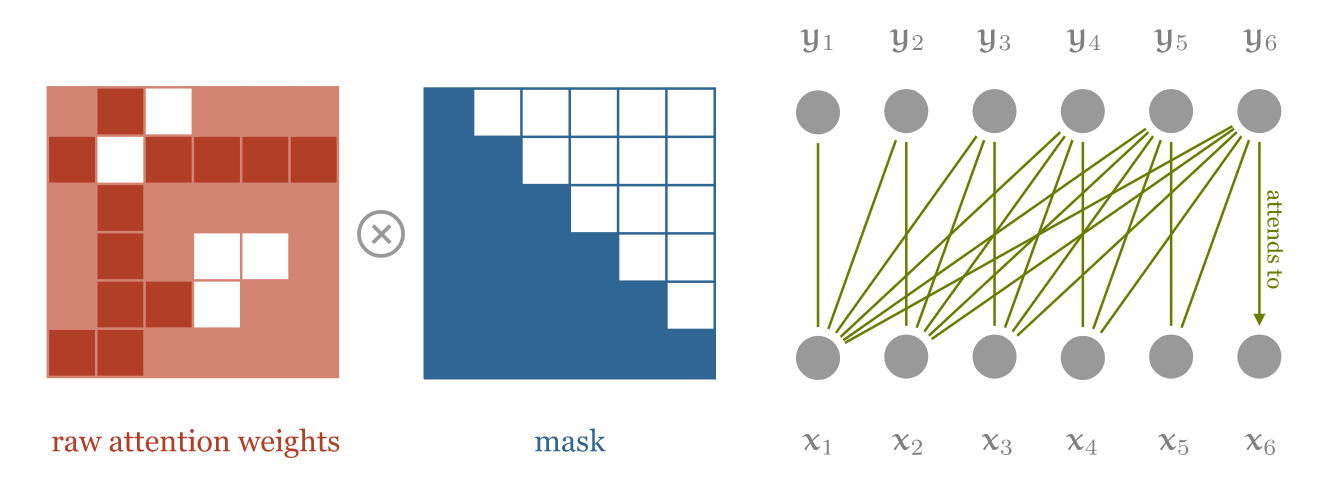

> Masking cho self attention để đảm bảo các elements chỉ có thể tham gia vào input elements đứng trước chúng trong sequence. Cần chú ý ở đây là kí hiệu nhân có thể gây hiểu nhầm: ta thực sự set các giá trị bị masked (các ô vuông trắng) thành $-\infty$

Do ta cần các elements đó sẽ trở thành zero (0) sau bước softmax, ta sẽ đặt chúng thành $-\infty$. Dưới đây là ví dụ với pytorch

In [ ]:
class NotSelfAttention(nn.Module):
  def __init__(self, k, heads=8):
    super().__init__()
    self.k = k
    self.heads = heads
    s = k // heads
    self.toqueries = nn.Linear(k, k * heads, bias = False)
    self.tokeys = nn.Linear(k, k * heads, bias = False)
    self.tovalues = nn.Linear(k, k * heads, bias = False)
    self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
    b, t, k = x.size()
    h = self.heads

    assert k == self.k, f'Input embedding dim ({k}) should match layer embedding dim ({self.k})'
    queries = self.toqueries(x).view(b,t,h,k)
    keys = self.tokeys(x).view(b,t,h,k)
    values = self.tovalues(x).view(b,t,h,k)
    queries = queries.transpose(1,2).contiguous().view(b*h, t, k)
    keys = keys.transpose(1,2).contiguous().view(b*h, t, k)
    values = values.transpose(1,2).contiguous().view(b*h, t, k)
    queries = queries / (k ** (1/4))
    keys = keys / (k ** (1/4))
    dot = torch.bmm(queries, keys.transpose(1,2))
    return dot

In [ ]:
np.random.seed(0)
torch.set_printoptions(sci_mode=None)
x_ = np.random.randint(1,10,(1,5,5))
x = torch.tensor(x_, dtype=torch.double)

b,t,k = x.size()
print("x size:", x.size())

s_ = NotSelfAttention(k, 8)(x.float())
print("s_ size:", s_.size())
print(s_)


indices = torch.triu_indices(t, t, offset=1)
print("\nindices:\n", indices)

x size: torch.Size([1, 5, 5])
s_ size: torch.Size([8, 5, 5])
tensor([[[ 3.8767e+00, -8.1169e+00, -3.6786e+00, -2.5243e+00, -2.6302e+00],
         [ 2.3823e+00, -5.8835e+00, -5.6473e+00, -5.3175e+00, -5.4519e+00],
         [-4.1959e+00, -9.6041e+00, -1.1707e+01, -1.1839e+01, -1.1031e+01],
         [-4.4606e+00, -1.0505e+01, -1.2034e+01, -1.1981e+01, -1.0837e+01],
         [ 3.0443e-01, -8.1243e+00, -6.7625e+00, -6.0270e+00, -5.2362e+00]],

        [[-2.1885e-01,  1.0225e+01,  1.6399e+01,  1.4134e+01,  6.9449e+00],
         [-5.4900e+00,  9.3066e-01,  8.0561e+00,  6.6753e+00,  5.5024e-01],
         [-3.3353e+00,  8.4625e+00,  1.1557e+01,  8.3020e+00,  1.4937e+00],
         [-3.5670e+00,  8.2288e+00,  1.1534e+01,  8.2441e+00,  1.3642e+00],
         [-5.0220e+00,  2.3518e+00,  6.5774e+00,  4.4917e+00, -4.9040e-01]],

        [[ 1.0399e+00, -2.7364e+00,  1.0853e+01,  1.3367e+01,  1.6004e+01],
         [ 3.3964e-01, -5.0494e+00,  6.5306e+00,  9.5637e+00,  1.6825e+01],
         [-5.0600e-01, 

In [ ]:

s_[:, indices[0], indices[1]] = float('-inf')
print("\nmasked matrix:\n", s_)


masked matrix:
 tensor([[[ 3.8767e+00,        -inf,        -inf,        -inf,        -inf],
         [ 2.3823e+00, -5.8835e+00,        -inf,        -inf,        -inf],
         [-4.1959e+00, -9.6041e+00, -1.1707e+01,        -inf,        -inf],
         [-4.4606e+00, -1.0505e+01, -1.2034e+01, -1.1981e+01,        -inf],
         [ 3.0443e-01, -8.1243e+00, -6.7625e+00, -6.0270e+00, -5.2362e+00]],

        [[-2.1885e-01,        -inf,        -inf,        -inf,        -inf],
         [-5.4900e+00,  9.3066e-01,        -inf,        -inf,        -inf],
         [-3.3353e+00,  8.4625e+00,  1.1557e+01,        -inf,        -inf],
         [-3.5670e+00,  8.2288e+00,  1.1534e+01,  8.2441e+00,        -inf],
         [-5.0220e+00,  2.3518e+00,  6.5774e+00,  4.4917e+00, -4.9040e-01]],

        [[ 1.0399e+00,        -inf,        -inf,        -inf,        -inf],
         [ 3.3964e-01, -5.0494e+00,        -inf,        -inf,        -inf],
         [-5.0600e-01, -7.3932e+00,  9.7214e+00,        -inf,      

In [ ]:
ssm_ = func.softmax(s_, dim=2)
torch.set_printoptions(sci_mode=False)
print("after softmax:\n", ssm_)

after softmax:
 tensor([[[    1.0000,     0.0000,     0.0000,     0.0000,     0.0000],
         [    0.9997,     0.0003,     0.0000,     0.0000,     0.0000],
         [    0.9950,     0.0045,     0.0005,     0.0000,     0.0000],
         [    0.9966,     0.0024,     0.0005,     0.0005,     0.0000],
         [    0.9933,     0.0002,     0.0008,     0.0018,     0.0039]],

        [[    1.0000,     0.0000,     0.0000,     0.0000,     0.0000],
         [    0.0016,     0.9984,     0.0000,     0.0000,     0.0000],
         [    0.0000,     0.0434,     0.9566,     0.0000,     0.0000],
         [    0.0000,     0.0342,     0.9311,     0.0347,     0.0000],
         [    0.0000,     0.0128,     0.8774,     0.1090,     0.0007]],

        [[    1.0000,     0.0000,     0.0000,     0.0000,     0.0000],
         [    0.9955,     0.0045,     0.0000,     0.0000,     0.0000],
         [    0.0000,     0.0000,     1.0000,     0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0385,     0.9615,

Nửa trên matrix bằng 0, ta có ma trận tam giác dưới khá ok sau khi softmax.

Sau khi ta vô hiệu hóa self-attention theo cách này, mô hình sẽ không thể nhìn về phía trước (look forward, ý ở đây tôi hiểu là nhìn trước được có cái gì trong seq) trong sequence được nữa.

Ta train mô hình với bộ dataset tiêu chuẩn là `enwik8` (lấy từ [Hutter prize](http://prize.hutter1.net/), dataset này sẽ bao gồm $10^8$ kí tự từ Wikipedia text (bao gồm cả markup). Trong quá trình training, ta sẽ sinh ra (generate) các batchs bằng cách lấy mẫu ngẫu nhiên những chuỗi phụ (subsequences) từ data.

Ta sẽ train trên sequence với độ dài 256, sử dụng 12 block transformer và chiều embedding là 256. Sau khoảng 24h training với RTX 2080Ti (khoảng 170k batchs size 32), ta sẽ cho mô hình sinh từ **1 seed 256 kí tự**: với mỗi kí tự, ta cấp cho nó 256 kí tự trước đó và xem nó dự đoán kí tự tiếp theo là gì (output vector cuối). Ta lấy mẫu từ đó với [temperature](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277) 0.5 và chuyển tới kí tự tiếp theo

Output sẽ trông thế này:

`
1228X Human & Rousseau. Because many of his stories were originally published in long-forgotten magazines and journals, there are a number of [[anthology|anthologies]] by different collators each containing a different selection. His original books have been considered an anthologie in the [[Middle Ages]], and were likely to be one of the most common in the [[Indian Ocean]] in the [[1st century]]. As a result of his death, the Bible was recognised as a counter-attack by the [[Gospel of Matthew]] (1177-1133), and the [[Saxony|Saxons]] of the [[Isle of Matthew]] (1100-1138), the third was a topic of the [[Saxony|Saxon]] throne, and the [[Roman Empire|Roman]] troops of [[Antiochia]] (1145-1148). The [[Roman Empire|Romans]] resigned in [[1148]] and [[1148]] began to collapse. The [[Saxony|Saxons]] of the [[Battle of Valasander]] reported the y
`

Chú ý rằng các cú pháp của tag link Wiki được sử dụng chính xác, các text bên trong các links biểu diễn chủ đề hợp lý cho các links (đại khái là những cái trong tag là khớp với links). Quan trọng nhất, là text ở đây đã có sự nhất quán về chủ đề; những text được sinh ra vẫn đang nói về 'the bible' và 'Roman empire', và chúng sử dụng những thuật ngữ khác nhau ở các điểm khác nhau. Kết quả này còn cách vô cùng xa với các mô hình như GPT-2, tuy nhiên ưu điểm của nó so với 1 mạng RNN tương tự là khá rõ ràng: training nhanh hơn (1 mô hình RNN tương tự mất tới vài ngày để train) và thể hiện những văn bản dài mạch lạc hơn.

> In case you're curious, the Battle of Valasander seems to be an invention of the network.

Ở thời điểm này, mô hình đạt được mật độ nén là 1.343 bits với mỗi byte trên tập validation, không quá tệ so với SOTA hiện tại là 0.93 bits per byte (GPT-2)

Phần này tôi sẽ không demo vì không có chút hiểu biết gì cả :P

# Design considerations

Để hiểu được tại sao transformer lại thiết kế như vậy, sẽ giúp ta hiểu được ý tưởng thiết kế cơ bản bên trong nó. Điểm chính của transformer chính là giải quyết những vấn đề của các kiến trúc SOTA trước đây, RNN (thường là 1 LSTM hoặc GRU). Một RNN được 'trải' (unrolled) ra sẽ như sau:

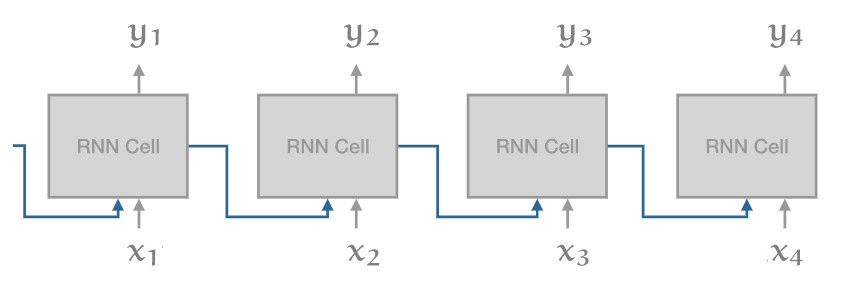

Điểm yếu lớn nhất ở đây chính là các <font color='blue'>kết nối lặp lại (recurrent connection)</font>. Các kết nối này cho phép thông tin lan truyền trong toàn sequence, nhưng nó cũng đồng nghĩa với việc ta không thể tính toán cell ở step $i$ mà không tính cell tại $i - 1$. Ngược lại với điều này là một 1D convolution:

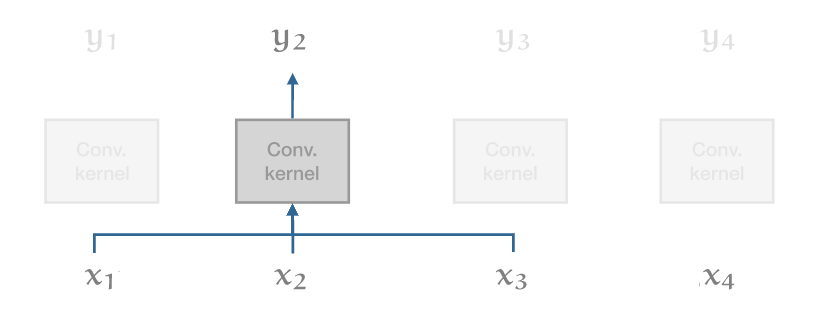

Trong mô hình này, mỗi ouput vector có thể được tính toán song song với mỗi output vector khác. Điều này khiến cho convolution chạy rất nhanh. Tuy nhiên nó cũng có nhược điểm chí mạng đó là vô cùng hạng chế trong việc mô hình hóa *phụ thuộc xa (long range dependencies)* (vd: 1 từ ở giữa câu liên quan đến cuối câu). Trong 1 lớp convolution, chỉ những từ gần nhau hơn kích thước của kernel mới tương tác với nhau. Đối với phụ thuộc xa, ta cần phải chồng (stack) nhiều lớp convolution.

Transformer được sinh ra để kết hợp những gì tốt nhất của cả 2 phương pháp trên. Nó có thể mô hình hóa sự phụ thuộc trên toàn bộ chiều dài của input sequence một các dễ dàng như cách nó làm với các từ đứng cạnh nhau (trên thực tế, nếu không có position vector, transformer không thể nhận biết được sự khác biệt đó). Và hơn nữa, ta không có các kết nối lặp (recurrent connections), nên toàn model có thể tính toán theo kiểu chuyển tiếp (feedforward) rất hiệu quả.

Phần còn lại của kiến trúc transformer chủ yếu dựa trên 1 yếu tố: độ sâu (depth). Hầu hết các lựa chọn độ sâu (depth) đều xuất phát từ mong muốn train một stack lớn các transformer block. Chú ý rằng trong transformer chỉ có 2 thời điểm các giá trị trở nên phi tuyến (non-linearities): softmax ở self-attention và ReLU ở lớp feedforward. Phần còn lại của mô hình toàn toàn tuyến tính (linear), đảm bảo hoàn hảo cho việc bảo toàn đạo hàm (which perfectly preserve the gradient).

> Ta có thể cho rằng lớp normalization cũng là lớp nonlinear, nhưng sự phi tuyến ở đây giúp giữ cho gradient ổn định khi nó lan truyền ngược lại mạng.

# Historycal baggage (Hoàn cảnh lịch sử)

Nếu bạn đã đọc những hướng dẫn khác về transformers, có thể thấy là trong bài này tôi đã 'skip' một số thứ. Tôi nghĩ rằng những thứ đó không cần thiết phải hiểu trong những kiến trúc transformer ngày nay. Tuy nhiên chúng vẫn rất hữu ích để hiểu các thuật ngữ và các bài viết về modern transformer. Đây là những ý quan trọng nhất.

## Why is it called self-attention?

Trước khi self-attention được giới thiệu, các sequence model hầu hết là các recurrent networks hoặc các convolution được xếp chồng. Ở một số điểm, người ta nhận ra rằng các mô hình này có thể được hỗ trợ bằng cách thêm vào *cơ chế attention*: thay vì đưa thẳng output sequence của lớp trước vào input của lớp sau, một cơ chế trung gian được giới thiệu nhằm đưa ra quyết định xem phần tử nào của input liên quan tới 1 từ cụ thể của output.

Cơ chế đó hoạt động như sau. Ta gọi input là `values`. Một số cơ chế (trainable) gán 1 `key` cho mỗi value. Sau đó với mỗi output, một cơ chế khác gán 1 `query`.

Cách đặt tên ở trên xuất phát từ cấu trúc dữ liệu của 1 hệ lưu trữ key-value. Trong đó, ta mong muốn rằng chỉ 1 item trong kho lưu trữ có 1 key khớp với query, khóa này sẽ được trả về khi ta thực hiện truy vấn. Attention là một phiên bản rút gọn hơn của nó: mọi key trong store đều khớp với query ở một mức độ nào đó. Tất cả đều được trả về sau đó, và ta sẽ tính sum, weight, theo mức độ mà mỗi key khớp với query.

Bước đột phá lớn của self-attention là bản thân nó đã là một cơ chế đủ mạnh để thực hiện tất cả việc 'learning'. ["Attention is all you need"](https://arxiv.org/abs/1706.03762), như tiêu đề tác giả đã đặt cho nó. Key, query, value, tất cả đều là các vector giống nhau (với các phép biến đổi tuyến tính (linear) nhỏ). Nó tự *chú ý (attend)* đến bản thân và chồng (stacking) những self-attention cung cấp đầy đủ tính phi tuyến và khả năng biểu diễn để học các hàm rất phức tạp (They attend to themselves and stacking such self-attention provides sufficient nonlinearity and representational power to learn very complicated functions.)

## The original transformer: encoders and decoders - Người tiền bối của Optimus Prime

Nhưng tác giả đã không phân tích hết toàn bộ sự phức tạp của các sequence modeling đương thời. Kiến trúc tiêu chuẩn của các mô hình seq-to-seq thời đó là một kiến trúc encoder-decoder, với dạy bắt buộc (teach forcing).

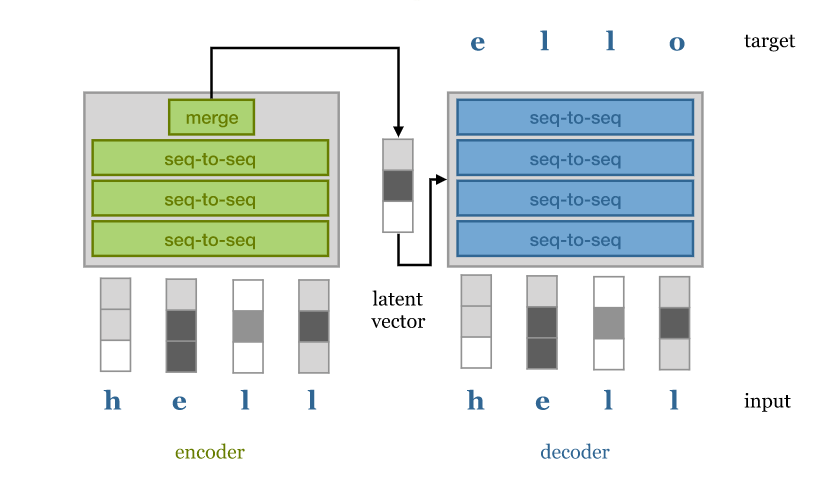

Phần *encoder* nhận input sequence và ánh xạ (map) nó thành một biểu diễn *ngầm* (latent representation) của toàn bộ sequence. Nó có thể là một chuỗi vector ẩn (latent vector) hoặc một vector đơn nhất như hình trên. Vector này sau đó được truyền tới một *decoder*, nơi mà nó được *giải nén (unpack)* thành sequence mục tiêu ta cần (vd: 2 câu giống nhau khác ngôn ngữ).

*Teacher forcing* đề cập đến một kĩ thuật cho phép decoder truy cập vào câu input, nhưng theo kiểu autoregressive (*?). Nghĩa là, decoder sẽ sinh ra từng câu từng chữ dựa trên latent vector và những từ đã được tạo ra. Điều này sẽ làm giảm bớt áp lực cho việc biểu diễn latent: decoder có thể lẫy mẫu từng từ (word-for-word sampling) để xử lý cấu trúc ở low-level như cú pháp và ngữ pháp của câu và sử dụng latent vector để nắm bắt nhiều hơn ngữ nghĩa cấu trúc ở high-level. Việc decode 2 lần với cùng 1 biểu diễn latent sẽ cung cấp cho ta2 câu khác nhau có cùng nghĩa.

Trong các transformer đời mới như BERT hay GPT-2, cách cấu hình encoder/decoder hoàn toàn tách biệt. Một stack đơn giản các transformer block được cho là đủ để đạt được SOTA trong nhiều task làm việc với sequence.

> Cách tiếp cận này đôi khi gọi là decoder-only transformer (cho một mô hình tự hồi quy autoregressive) hoặc là encoder-only transformer (cho một mô hình không sử dụng masking)



## Modern transformer - Các mô hình transfomer hiện đại

Dưới đây là một số mô hình và các đặc điểm của chúng

### BERT

BERT là một trong những model đầu tiên thể hiện rằng transformer có thể đạt tới ngưỡng khả năng của con người trong nhiều task về ngôn ngữ: question answering, sentiment classification hoặc phân loại liệu 2 câu có nối tiếp nhau hay không (classifying whether two sentences naturally follow one another.)

BERT bao gồm 1 stack đơn giản của các transformer blocks, giống như cái mà ta đã đề cập ở trên. Stack này là *pre-trained* trên một kho dữ liệu bao gồm 800 triệu từ trong các sách tiếng Anh (modern work, from unpublished authors), và 2.5 tỉ từ được lấy từ English Wikipedia (không có markup).

Pretraining được thực hiện thông qua 2 task:

**Masking**: Một số lượng từ nhất định trong sequence sẽ được: giấu đi (masked out), thay thế (replaced) bằng một từ ngẫu nhiên hoặc giữ nguyên. Mô hình sẽ phải dự đoán từ gốc ở những từ này. Chú ý rằng mô hình không cần thiết phải dự đoán toàn bộ câu, mà chỉ cần đoán những từ đã được thay thế. Do mô hình không biết được từ nào đang được yêu cầu, nó sẽ học cách biểu diễn cho mọi từ trong sequence.

**Next sequence classification**: 2 sequence với khoảng 256 từ được lấy mẫu sao cho a) nối tiếp nhau trong corpus (kho ngữ liệu), hoặc b) cả 2 đều được lấy từ các vị trí ngãu nhiên. Và mô hình sẽ phải dữ đoán đó là trường hợp a hay b

BERT sử dụng WordPiece tokenization, để tokenize sequence ở mức giữa cấp độ từ và cấp độ kí tự. Nó sẽ chia từ như `walking` thành các token `walk` và `##ing`. Điều này cho phép model có thể dự đưa ra một số dự đoán dựa trên cấu trúc từ: 2 động từ kết thúc với đuôi `-ing` sẽ có cùng chức năng ngữ pháp, và 2 từ bắt đầu với `walk-` sẽ có cùng chức năng ngữ nghĩa.

Ta sẽ thjeem vào đầu input một token đặc biệt `<cls>`. Output vector tương ứng với token này được sử dụng như một biểu diễn cho cầu trong task phân lớp câu (sentence classification) như là dự đoán câu tiếp theo (next sentence classification) (trái ngược với trung bình pooling toàn cục qua toàn bộ vector (global average pooling over all vectors) mà ta đã dùng ở mô hình phân lớp ở trên)

Sau pretraining, một lớp cho một task đặc thù được đặt sau phần transformer, nhằm ánh xạ phần biểu diễn chung (general purpose representation) để cho ra một output cụ thể. Đối với task phân lớp, ta chỉ cần ánh xạ ouput token đầu tiên với một hàm softmax để cho ra xác suất của các lớp. Với các task phức tạp hơn, một lớp seq-to-seq sẽ được thiết kế riêng để xử lý task đó.

Toàn bộ model sau đó sẽ được train lại nhằm finetune (tinh chỉnh) lại model cho task mà ta muốn.

Trong một thử nghiệm, tác giả đã cho thấy sự vượt trội so với các mô hình tiền nhiệm nhờ dựa vào bản chất 2 chiều của BERT (Bidirectional Encoder Representations from Transformers). Có nghĩa là, các mô hình trước đây như GPT sử dụng một mask tự hồi quy (autoregressive mask), chỉ cho phép attention các token ở trước (một chiều trái->phải/phải->trái). Còn BERT cho phép attention trên toàn bộ sequence với mục đích nhằm tăng performance. (hai chiều trái<->phải)

> Đó là lí do tại sao chữ B trong BERT đại diện cho "bidirectional" (hai chiều).

Model BERT lớp nhất sử dụng 24 transformer blocks, với chiều embedding là 1024 và 16 attention heads, với tổng cộng 340 triệu tham số.

### GPT-2

GPT-2 là mô hình transformer đầu tiên được lên báo truyền thông, sau quyết định gây tranh cãi của OpenAI là không release full version của mô hình (cái lũ kibo).

> Lý giải cho điều này, GPT-2 có thể tạo ra những fake-news nghe vô cùng 'legit' và khả năng/chiến dịch viết lách bịa chuyện của nó tương đương với một nhà báo thực sự

Kĩ thuật đầu tiên mà tác giả của GPT-2 đề cập đến chính là việc tạo ra một bộ dataset chất lượng cao. Trong khi BERT cũng dùng một nguồn data chất lượng tốt, tuy nhiên nguồn data của họ (sách viết tay và các bài wikipedia) không thống nhất trong cách hành văn, phong cách viết (style). Để thu thập nhiều dữ liệu hơn mà không phải đánh đổi chất lượng, tác giả sử dụng những đường link trên Reddit để thu thập một lượng lớn các bài viết được đánh giá ở một mức độ có ích nhất định (trong reddit gọi là *karma*).

GPT2 về cơ bản là một *mô hình sinh* (generation) ngôn ngữ, nên nó sẽ dùng masked self-attention như ta đã đề cập ở trên (phần Text generation). Nó dùng mã hóa byte-pair để tokenize ngôn ngữ, giống như WordPiece chia từ thành các token lớn hơn 1 kí tự nhưng nhỏ hơn 1 từ.

GPT2 được xây dựng giống như text generation model của ta ở trên, với một số thay đổi nhỏ trong thứ tự các lớp và thêm vào một số kĩ thuật để train với độ sâu (depth) lớn. Mô hình lớn nhất dùng 48 transformer block, một chuỗi sẽ dài 1024 và chiều embedding là 1600, ta sẽ có tổng tham số cho model là 1.5 tỉ tham số.

GPT2 đã đạt SOTA ở nhiều task. Trên bộ data nén wiki chúng ta thử ở trên, GPT2 đạt 0.93 bits per byte.

### Transformer-XL

Trong khi transformer đại diện cho một bước nhảy vọt trong mô hình hóa phụ thuộc xa (long-range dependency), các mô hình chúng ta biết cho tới này vẫn bị giới hạn bởi kích thước input. Vì kích thước của matrix dot-product tăng theo cấp bình phương, điều này nhanh chóng trở này nút cổ chai (bottleneck) khi chúng ta cố tăng dộ dài của input sequence. Transformer-XL là một trong những mô hình đầu tiên giải quyết thành công vấn đề này.

Trong quá trình training, một sequence text dài (dài hơn cả mức model xử lí được) được chia thành các đoạn ngắn hơn (segments). Mỗi đoạn sẽ được xử lí trong chuỗi, với self-attention được tính toán qua các token trong đoạn hiện tại và *đoạn trước đó*. Đạo hàm (gradients) chỉ được tính thông qua segment hiện tại, nhưng thông tin vẫn được lan truyền khi cửa sổ phân đoạn di chuyển văn bản. Về lí thuyết, ở lớp $n$, thông tin vẫn có thể được sử dụng từ $n$ segment trước đó.

> Một kĩ thuật tương tự trong khi train RNN được gọi là "lan truyền ngược cắt ngắn qua thời gian" (truncated backpropagation through time). Ta đưa vào model một sequence rất dài, nhưng chỉ lan truyển ngược lại một phần của nó. Phần đầu tiên của sequence không được tính đạo hàm vẫn ảnh hưởng đến các trạng thái ẩn (hidden states) trong phần mà chúng đang đứng.

Để kĩ thuật này hoạt động, tác giả đã bỉ qua kĩ thuật position encoding/embedding. Vì position encoding là *tuyệt đối (absolute)*, nó dẫn đến việc embedding không nhất quán trên toàn bộ sequence. Thay vào đó, họ sử dụng kĩ thuật encoding *có quan hệ (relative)*. Với mỗi output vector, một sequence khác của position vector không được dùng để biểu thị vị trí tuyệt đối mà là khoảng cách tới output hiện tại.

Điều này sẽ cần đưa position encoding vào trong kĩ thuật attention (chi tiết trong paper). Ưu điểm của phương pháp này là nó có kết quả sinh ra của nó tối hơn với những sequence có độ dài chưa từng biết.

### Sparse transformer

Sparse transformer giải quyết vấn đề sử dụng bộ nhớ (quadratic memory use). Thay vì tính toán trọng số attention là 1 dense matrix (lượng tham số tăng theo cấp bình phương), thì ta sẽ chỉ tính self-attention cho những cặp riêng biệt của input token, kết quả của ta sẽ là 1 matrix *thưa (sparse)* chỉ có $n \sqrt n$ phần tử.

Điều này sẽ cho phép mô hình chứa lượng ngữ cảnh (context) rất lớn, chẳng hạn như mô hình hóa sinh hình ảnh, với sự phụ thuộc lớn giữa các pixel với nhau (for instance for generative modeling over images, with large dependencies between pixels). Đánh đổi cho điều đó là cấu trúc thưa (sparsity) không được học, việc lựa chọn sparse matrix, ta đang tắt đi một vài tương tác giữa các input token có thể hữu ích. Dẫu vậy, 2 đơn vị không trực tiếp liên quan đến nhau vẫn có thể tương tác với nhau ở các tầng cao hơn của transformer (giống như cách convolutional net xây dựng một trường tiếp cận lớn với nhiều lớp convolution)

Bên cạnh tính đơn giản trong việc train transformer với độ dài sequence rất lớn, sparse transformer cũng cho phép thiết kế inductive bias một cách rất tinh tế. Ta lấy các input vào như một tập các đơn vị (words, characters, pixel trong ảnh, node trong graph) và ta chỉ định, thông qua sự thưa thớt của attention matrix, những đơn vị mà ta tin là có liên quan.(We take our input as a collection of units (words, characters, pixels in an image, nodes in a graph) and we specify, through the sparsity of the attention matrix, which units we believe to be related). Phần còn lại chỉ là vấn đề build transformer càng sâu càng tốt để xem nó hoạt động thế nào thôi.

# Going big

Nút cổ chai lớn nhất trong training transformer là matrix dot-product trong self-attention. Cho dột dài sequence là $t$, ta có một dense matrix gồm $t^2$ phần tử. Trong hệ 32-bit tiêu chuẩn, với $t = 1000$, một batch kích thước 16 sẽ dùng khoảng `250MB` bộ nhớ. Và ta cần tối thiểu 4 trong số chúng cho mỗi bước self-attention (trước và sau softmax, cộng với gradient của chúng), điều này sẽ giới hạn ta ở 12 layers với một GPU có `12GB` bộ nhớ. Trong thực tế, ta có thể còn có ít lớp hơn, vì cả input và output đều dùng rất nhiều bộ nhớ (mặc dù dot-product chiếm hầu hết).

Tuy nhiên các mô hình được ghi nhận trong bài báo chưa độ dài sequence khoảng 12000, với 48 lớp và sử dụng dense dot-product matrix. Tất nhiên những mô hình này được train trên các cụm, nhưng 1 GPU vẫn cần được dùng để tính toán lan truyền tiến/ngược (forward/backward pass). Vậy làm thế nào ta có thể nhồi nhét từng đó thông tin của transformer vào 12GB bộ nhớ? Ta dùng 3 kĩ thuật sau:

**Half precision**: trên các GPU và TPU ngày nay, việc tính toán các tensor hiệu quả trên các tensor 16-bit float. Điều này không đơn giản chỉ là set dtype của tensor thành `torch.float16`. Với một số phần của mạng, giống như loss, sẽ bắt buộc phải sử dụng hệ 32-bit. Tuy nhiên hầu hết những vấn đề này có thể giải quyết bởi [những thư viện có sẵn](https://github.com/NVIDIA/apex). Thực tế là điều này sẽ tăng gấp đôi hiệu quả về bộ nhớ.

**Gradient accumulation**: Đối với một model lớn, ta có thể chỉ có khả năng thực hiện lan truyền forward/backward cho một mẫu đơn lẻ. Và batch_size=1 thì dẫn đến việc học của mô hình không ổn định. May mắn thay, ta có thể thực hiện điều đó cho mỗi mẫu trong 1 batch lớn hơn, và chỉ đơn giản tính tông gradient tìm được (đây là hệ quả của quy tắc chuỗi đa biến - multivariate chain rule). Khi kết thúc batch, ta sẽ thực hiện một bước giảm độ dốc (gradient decent), và loại bỏ gradient (zero out the gradient). Trong Pytorch, điều này khá là dễ dàng với hàm `optimizer.zero_grad()` nhìn có vẻ vô dụng trong vòng loop. Nhưng nếu ta không gọi nó thì gradient mới sẽ được cộng vào với cái cũ.

**Gradient checkpointing**: nếu model quá lớn tới mức không đủ bộ nhớ để thực hiện forward/backward pass, ta có thể đánh đổi việc tính toán hơn nữa để đảm bảo bộ nhớ. Trong kĩ thuật này, model sẽ được chia thành nhiều phần. Với mỗi phần, chúng ta sẽ để thực hiện forward/backward độc lập để tính toán gradient mà không giữ lại các giá trị trung gian của phần còn lại. Pytorch có các công cụ chuyên biệt cho việc đó. [ref](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255)

# Kết luận - Conclusion

Transformer có thể là kiến trúc đơn giản nhất sẽ thống trị lĩnh vực này trong nhiều năm tới. Có nhiều lí do để ta chú ý vào kiến trúc này hơn.

Đầu tiên, **hiệu năng hiện tại bị giới hạn bởi phần cứng**. Không giống như convolution hay LSTM, những giới hạn hiện tại với chúng hoàn toàn được quyết định bởi độ lớn của mô hình đối với bộ nhớ GPU, và bao nhiêu data ta có thể đẩy qua nó trong 1 khoảng thời gian hợp lí. Không nghi ngờ gì khi cuối cùng ta cũng sẽ đạt đến điểm mà nhiều lớp và nhiều dữ liệu hơn cũng chẳng tốt hơn là bao, nhưng có vẻ như ta chưa đạt tới điểm đó.

Thứ hai, **transformer rất chung chung (generic)** (?). Tới nay (2019), thành công lớn nhất transformer đạt được là các mô hình ngôn ngữ, với những kết quả khiêm tốn hơn ở mảng âm thanh và âm nhạc, nhưng transformer có khả năng tổng quát chờ được khai phá, trong năm 2022 thì chúng ta đã được chứng kiến sự thành công của VisionTransformer. Một transformer cơ bản là một mô hình *set-to-set*. Nên cho đến khi data còn là một tập các đơn vị, ta vẫn có thể sử dụng transformer. Bất kì những gì ta biết về data (như cấu trúc nội bộ) có thể được thêm vào như 1 position embeddings, hoặc thao túng (manipulating) cấu trúc của attetion matrix (tạo ra sự thưa thớt (sparse), hoặc masking các phần).

Điều này trong thực tế có thể hữu dụng trong việc học đa phương thức. Ta có thể dễ dàng kết hợp một mô tả ảnh với một tập các pixel và kí tự và thiết kế embedding và sparisity một cách tinh tế để giúp mô hình tìm ra cách kết hợp và align cả 2. Nếu ta kết hợp toàn bộ những kiến thức đã có về miền thông tin vào trong một cấu trúc có quan hệ như 1 đồ thị thông tin đa phuong thức (multi-modal knowledge graph) (như ta đã nhắc ở [3]), các khối transformer đơn giản có thể được thiết kế để lan truyền thông tin giữa các đơn vị multimodal, và sắp xếp chúng với cấu trúc thưa thớt (sparsity) cung cấp khả nawg kiểm soát các đơn vị đang tương tác trực tiếp.

Cho đến nay (2019), transformer vẫn đang được coi là một mô hình ngôn ngữ. Nhưng tôi hi vọng trong trương lai, ta có thể nhìn thấy nó được sử dụng ở nhiều lĩnh vực khác nhau, không chỉ để tăng tương performance mà còn cả những model đã tồn tại, và cho phép các nhà khoa học kiếm soát trực quan hơn với các mô hình quy nạp của họ.

#REF

[1] The illustrated transformer, Jay Allamar.

[2] The annotated transformer, Alexander Rush.

[3] The knowledge graph as the default data model for learning on heterogeneous knowledge Xander Wilcke, Peter Bloem, Victor de Boer

[4] Matrix factorization techniques for recommender systems Yehuda Koren et al.

